<a href="https://colab.research.google.com/github/dmalya96/GAN/blob/main/Vanilla_GAN_Cifar10_IGMD_Layers_Bird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Vanilla GAN on Cifar 10 (Bird Images)

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from matplotlib import pyplot

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = tf.keras.Sequential()
  # foundation for 4x4 image
  model.add(layers.Dense(4*4*512, use_bias=False, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((4, 4, 512)))
  # upsample to 8x8
  model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # output layer
  model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
  return model

In [ ]:
# define the standalone discriminator model
def define_discriminator():
  model = tf.keras.Sequential()
  # normal
  model.add(layers.Conv2D(96, (3,3), padding='same', input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU(alpha=0.2))
  # downsample
  model.add(layers.Conv2D(96, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(96, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(192, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # classifier
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
  # load cifar10 dataset
  (trainX, trainY), (_, _) = tf.keras.datasets.cifar10.load_data()
  # Select bird images (Class 2)
  trainX = trainX[trainY.flatten() == 2]
  # convert from unsigned ints to floats
  X = trainX.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=5):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png'
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# generate images
	latent_points = generate_latent_points(100, 100)
	X = g_model.predict(latent_points)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot the result
	create_plot(X, 5)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 5 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

170500096/170498071 [==============================] - 3s 0us/step
>1, 1/39, d1=0.694, d2=0.696 g=0.692
>1, 2/39, d1=0.661, d2=0.697 g=0.691
>1, 3/39, d1=0.576, d2=0.715 g=0.677
>1, 4/39, d1=0.310, d2=0.895 g=0.595
>1, 5/39, d1=0.112, d2=1.275 g=0.581
>1, 6/39, d1=0.196, d2=1.023 g=0.642
>1, 7/39, d1=0.312, d2=0.816 g=0.686
>1, 8/39, d1=0.261, d2=0.709 g=0.722
>1, 9/39, d1=0.157, d2=0.651 g=0.835
>1, 10/39, d1=0.156, d2=0.564 g=1.206
>1, 11/39, d1=0.094, d2=0.448 g=1.939
>1, 12/39, d1=0.068, d2=0.451 g=1.947
>1, 13/39, d1=0.295, d2=0.915 g=0.902
>1, 14/39, d1=0.457, d2=0.642 g=0.758
>1, 15/39, d1=0.177, d2=0.665 g=0.747
>1, 16/39, d1=0.128, d2=0.780 g=0.750
>1, 17/39, d1=0.121, d2=0.767 g=0.751
>1, 18/39, d1=0.155, d2=1.038 g=0.770
>1, 19/39, d1=0.189, d2=0.678 g=0.864
>1, 20/39, d1=0.288, d2=0.640 g=0.837
>1, 21/39, d1=0.081, d2=0.610 g=0.979
>1, 22/39, d1=0.070, d2=0.560 g=0.885
>1, 23/39, d1=0.013, d2=0.597 g=0.827
>1, 24/39, d1=0.002, d2=0.599 g=0.839
>1, 25/39, d1=0.004, d2=0.585 

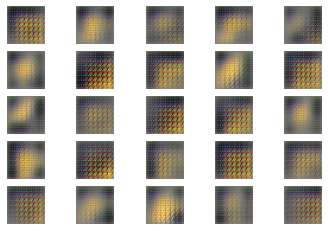

>6, 1/39, d1=0.360, d2=0.287 g=1.699
>6, 2/39, d1=0.633, d2=0.408 g=1.450
>6, 3/39, d1=0.396, d2=0.353 g=1.470
>6, 4/39, d1=0.508, d2=0.343 g=1.540
>6, 5/39, d1=0.469, d2=0.275 g=1.728
>6, 6/39, d1=0.428, d2=0.282 g=1.614
>6, 7/39, d1=0.369, d2=0.309 g=1.599
>6, 8/39, d1=0.400, d2=0.366 g=1.590
>6, 9/39, d1=0.482, d2=0.315 g=1.653
>6, 10/39, d1=0.362, d2=0.322 g=1.688
>6, 11/39, d1=0.445, d2=0.299 g=1.847
>6, 12/39, d1=0.561, d2=0.329 g=1.779
>6, 13/39, d1=0.605, d2=0.307 g=1.675
>6, 14/39, d1=0.405, d2=0.281 g=1.825
>6, 15/39, d1=0.623, d2=0.272 g=1.806
>6, 16/39, d1=0.494, d2=0.321 g=1.436
>6, 17/39, d1=0.419, d2=0.612 g=1.292
>6, 18/39, d1=0.342, d2=0.624 g=1.544
>6, 19/39, d1=0.637, d2=0.440 g=1.511
>6, 20/39, d1=0.571, d2=0.399 g=1.496
>6, 21/39, d1=0.530, d2=0.477 g=1.286
>6, 22/39, d1=0.525, d2=0.478 g=1.396
>6, 23/39, d1=0.602, d2=0.568 g=1.266
>6, 24/39, d1=0.587, d2=0.572 g=1.254
>6, 25/39, d1=0.427, d2=0.543 g=1.338
>6, 26/39, d1=0.580, d2=0.456 g=1.637
>6, 27/39, d1=0.512, 

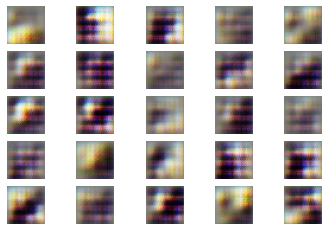

>11, 1/39, d1=0.354, d2=0.365 g=1.665
>11, 2/39, d1=0.302, d2=0.457 g=1.878
>11, 3/39, d1=0.349, d2=0.346 g=2.064
>11, 4/39, d1=0.507, d2=0.541 g=2.151
>11, 5/39, d1=0.755, d2=0.363 g=1.763
>11, 6/39, d1=0.337, d2=0.781 g=2.143
>11, 7/39, d1=0.869, d2=0.402 g=1.493
>11, 8/39, d1=0.604, d2=0.526 g=1.238
>11, 9/39, d1=0.277, d2=0.607 g=1.377
>11, 10/39, d1=0.413, d2=0.425 g=1.473
>11, 11/39, d1=0.451, d2=0.403 g=1.509
>11, 12/39, d1=0.420, d2=0.464 g=1.533
>11, 13/39, d1=0.486, d2=0.499 g=1.520
>11, 14/39, d1=0.467, d2=0.514 g=1.561
>11, 15/39, d1=0.573, d2=0.493 g=1.620
>11, 16/39, d1=0.618, d2=0.378 g=1.514
>11, 17/39, d1=0.592, d2=0.821 g=1.591
>11, 18/39, d1=0.355, d2=0.361 g=1.819
>11, 19/39, d1=0.503, d2=0.311 g=1.673
>11, 20/39, d1=0.422, d2=0.700 g=1.960
>11, 21/39, d1=0.646, d2=0.391 g=1.938
>11, 22/39, d1=0.625, d2=0.387 g=1.714
>11, 23/39, d1=0.641, d2=0.311 g=1.601
>11, 24/39, d1=0.647, d2=0.511 g=1.469
>11, 25/39, d1=0.611, d2=0.334 g=1.617
>11, 26/39, d1=0.610, d2=0.404 g=1

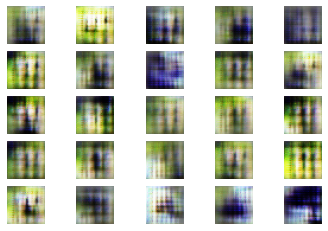

>16, 1/39, d1=0.469, d2=0.425 g=1.342
>16, 2/39, d1=0.610, d2=0.495 g=1.223
>16, 3/39, d1=0.590, d2=0.945 g=1.232
>16, 4/39, d1=0.714, d2=0.509 g=1.247
>16, 5/39, d1=0.751, d2=0.588 g=1.178
>16, 6/39, d1=0.777, d2=0.487 g=1.144
>16, 7/39, d1=0.666, d2=0.537 g=1.030
>16, 8/39, d1=0.590, d2=0.556 g=0.989
>16, 9/39, d1=0.515, d2=0.571 g=1.025
>16, 10/39, d1=0.562, d2=0.590 g=1.058
>16, 11/39, d1=0.619, d2=0.647 g=1.068
>16, 12/39, d1=0.582, d2=0.567 g=1.100
>16, 13/39, d1=0.671, d2=0.598 g=1.118
>16, 14/39, d1=0.613, d2=0.612 g=1.284
>16, 15/39, d1=0.623, d2=0.464 g=1.397
>16, 16/39, d1=0.648, d2=0.501 g=1.262
>16, 17/39, d1=0.545, d2=0.534 g=1.183
>16, 18/39, d1=0.589, d2=0.641 g=1.101
>16, 19/39, d1=0.583, d2=0.576 g=1.108
>16, 20/39, d1=0.538, d2=0.596 g=1.116
>16, 21/39, d1=0.524, d2=0.576 g=1.154
>16, 22/39, d1=0.643, d2=0.930 g=0.930
>16, 23/39, d1=0.739, d2=0.939 g=0.978
>16, 24/39, d1=0.664, d2=0.667 g=1.300
>16, 25/39, d1=0.754, d2=0.621 g=1.313
>16, 26/39, d1=0.650, d2=0.627 g=1

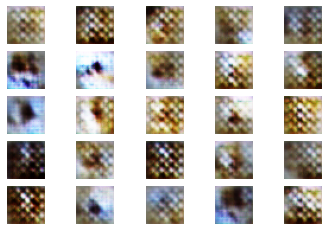

>21, 1/39, d1=0.595, d2=0.701 g=0.981
>21, 2/39, d1=0.637, d2=0.555 g=1.028
>21, 3/39, d1=0.576, d2=0.526 g=1.060
>21, 4/39, d1=0.601, d2=0.511 g=1.109
>21, 5/39, d1=0.591, d2=0.508 g=1.107
>21, 6/39, d1=0.489, d2=0.657 g=1.221
>21, 7/39, d1=0.631, d2=0.462 g=1.162
>21, 8/39, d1=0.500, d2=0.454 g=1.164
>21, 9/39, d1=0.569, d2=0.542 g=1.159
>21, 10/39, d1=0.514, d2=0.620 g=1.163
>21, 11/39, d1=0.666, d2=0.446 g=1.123
>21, 12/39, d1=0.680, d2=0.515 g=1.086
>21, 13/39, d1=0.601, d2=0.608 g=1.043
>21, 14/39, d1=0.539, d2=0.560 g=1.051
>21, 15/39, d1=0.524, d2=0.598 g=1.087
>21, 16/39, d1=0.541, d2=0.579 g=1.052
>21, 17/39, d1=0.484, d2=0.688 g=1.092
>21, 18/39, d1=0.508, d2=0.655 g=1.079
>21, 19/39, d1=0.677, d2=0.601 g=1.113
>21, 20/39, d1=0.604, d2=0.490 g=1.263
>21, 21/39, d1=0.611, d2=0.428 g=1.363
>21, 22/39, d1=0.513, d2=0.430 g=1.389
>21, 23/39, d1=0.511, d2=0.463 g=1.286
>21, 24/39, d1=0.525, d2=0.594 g=1.244
>21, 25/39, d1=0.425, d2=0.779 g=1.366
>21, 26/39, d1=0.627, d2=0.446 g=1

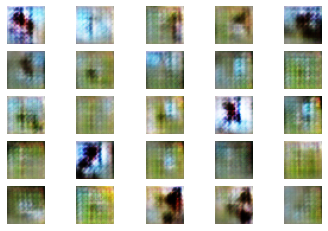

>26, 1/39, d1=0.319, d2=0.317 g=1.902
>26, 2/39, d1=0.470, d2=0.591 g=1.649
>26, 3/39, d1=0.439, d2=0.674 g=1.728
>26, 4/39, d1=0.762, d2=0.473 g=1.574
>26, 5/39, d1=0.702, d2=0.524 g=1.461
>26, 6/39, d1=0.557, d2=0.460 g=1.443
>26, 7/39, d1=0.529, d2=0.468 g=1.502
>26, 8/39, d1=0.534, d2=0.429 g=1.503
>26, 9/39, d1=0.529, d2=0.727 g=1.459
>26, 10/39, d1=0.485, d2=0.484 g=1.602
>26, 11/39, d1=0.538, d2=0.610 g=1.567
>26, 12/39, d1=0.596, d2=0.512 g=1.588
>26, 13/39, d1=0.465, d2=0.726 g=1.521
>26, 14/39, d1=0.654, d2=0.661 g=1.692
>26, 15/39, d1=0.578, d2=0.548 g=1.756
>26, 16/39, d1=0.709, d2=0.488 g=1.450
>26, 17/39, d1=0.427, d2=0.417 g=1.490
>26, 18/39, d1=0.478, d2=0.393 g=1.618
>26, 19/39, d1=0.476, d2=0.571 g=1.671
>26, 20/39, d1=0.515, d2=0.523 g=1.613
>26, 21/39, d1=0.563, d2=0.566 g=1.770
>26, 22/39, d1=0.640, d2=0.515 g=1.641
>26, 23/39, d1=0.612, d2=0.586 g=1.542
>26, 24/39, d1=0.483, d2=0.423 g=1.523
>26, 25/39, d1=0.412, d2=0.482 g=1.628
>26, 26/39, d1=0.397, d2=0.357 g=1

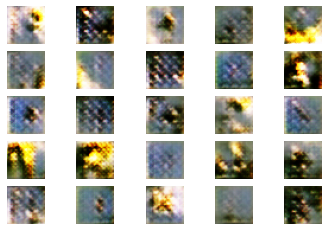

>31, 1/39, d1=0.572, d2=0.674 g=1.703
>31, 2/39, d1=0.610, d2=0.402 g=1.643
>31, 3/39, d1=0.588, d2=0.683 g=1.863
>31, 4/39, d1=0.518, d2=0.427 g=1.771
>31, 5/39, d1=0.588, d2=0.559 g=1.550
>31, 6/39, d1=0.534, d2=0.407 g=1.706
>31, 7/39, d1=0.429, d2=0.411 g=1.648
>31, 8/39, d1=0.338, d2=0.497 g=1.834
>31, 9/39, d1=0.545, d2=0.545 g=1.734
>31, 10/39, d1=0.424, d2=0.543 g=1.802
>31, 11/39, d1=0.419, d2=0.457 g=1.766
>31, 12/39, d1=0.493, d2=0.440 g=1.777
>31, 13/39, d1=0.375, d2=0.590 g=1.826
>31, 14/39, d1=0.329, d2=0.600 g=1.973
>31, 15/39, d1=0.596, d2=0.458 g=1.921
>31, 16/39, d1=0.603, d2=0.875 g=1.881
>31, 17/39, d1=0.732, d2=0.315 g=1.634
>31, 18/39, d1=0.935, d2=0.882 g=1.415
>31, 19/39, d1=0.696, d2=0.861 g=1.412
>31, 20/39, d1=0.783, d2=0.454 g=1.455
>31, 21/39, d1=0.833, d2=0.376 g=1.375
>31, 22/39, d1=0.682, d2=0.476 g=1.416
>31, 23/39, d1=0.609, d2=0.381 g=1.389
>31, 24/39, d1=0.618, d2=0.426 g=1.374
>31, 25/39, d1=0.462, d2=0.445 g=1.626
>31, 26/39, d1=0.517, d2=0.366 g=1

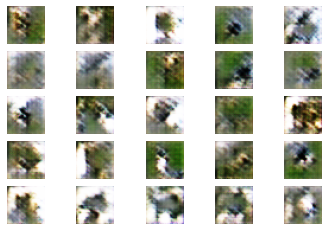

>36, 1/39, d1=0.401, d2=0.617 g=1.642
>36, 2/39, d1=0.662, d2=0.428 g=1.467
>36, 3/39, d1=0.543, d2=0.471 g=1.426
>36, 4/39, d1=0.348, d2=0.597 g=1.590
>36, 5/39, d1=0.543, d2=0.393 g=1.513
>36, 6/39, d1=0.612, d2=0.557 g=1.499
>36, 7/39, d1=0.503, d2=0.641 g=1.551
>36, 8/39, d1=0.585, d2=0.448 g=1.377
>36, 9/39, d1=0.541, d2=0.658 g=1.657
>36, 10/39, d1=0.574, d2=0.469 g=1.782
>36, 11/39, d1=0.559, d2=0.678 g=2.007
>36, 12/39, d1=0.685, d2=0.332 g=1.733
>36, 13/39, d1=0.474, d2=0.983 g=1.480
>36, 14/39, d1=0.518, d2=0.672 g=1.533
>36, 15/39, d1=0.761, d2=0.641 g=1.629
>36, 16/39, d1=1.046, d2=0.413 g=1.789
>36, 17/39, d1=0.897, d2=0.358 g=1.655
>36, 18/39, d1=0.712, d2=0.532 g=1.314
>36, 19/39, d1=0.792, d2=0.540 g=1.183
>36, 20/39, d1=0.682, d2=0.564 g=1.139
>36, 21/39, d1=0.723, d2=0.689 g=1.097
>36, 22/39, d1=0.655, d2=1.039 g=1.432
>36, 23/39, d1=0.888, d2=0.433 g=1.236
>36, 24/39, d1=0.794, d2=0.495 g=1.177
>36, 25/39, d1=0.686, d2=0.539 g=1.155
>36, 26/39, d1=0.541, d2=0.495 g=1

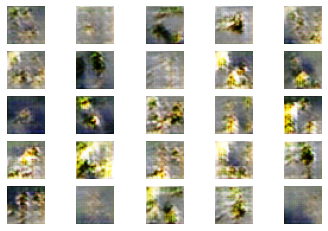

>41, 1/39, d1=0.414, d2=0.490 g=1.575
>41, 2/39, d1=0.701, d2=0.676 g=1.563
>41, 3/39, d1=0.630, d2=0.475 g=1.551
>41, 4/39, d1=0.613, d2=0.651 g=1.511
>41, 5/39, d1=0.648, d2=0.450 g=1.523
>41, 6/39, d1=0.512, d2=0.437 g=1.469
>41, 7/39, d1=0.507, d2=0.756 g=1.508
>41, 8/39, d1=0.526, d2=0.414 g=1.427
>41, 9/39, d1=0.626, d2=0.499 g=1.365
>41, 10/39, d1=0.496, d2=0.463 g=1.421
>41, 11/39, d1=0.491, d2=0.441 g=1.421
>41, 12/39, d1=0.472, d2=0.548 g=1.462
>41, 13/39, d1=0.478, d2=0.622 g=1.513
>41, 14/39, d1=0.747, d2=0.527 g=1.403
>41, 15/39, d1=0.428, d2=0.599 g=1.503
>41, 16/39, d1=0.502, d2=0.399 g=1.543
>41, 17/39, d1=0.536, d2=0.407 g=1.399
>41, 18/39, d1=0.495, d2=0.562 g=1.586
>41, 19/39, d1=0.512, d2=0.620 g=1.776
>41, 20/39, d1=0.670, d2=0.367 g=1.640
>41, 21/39, d1=0.658, d2=0.561 g=1.458
>41, 22/39, d1=0.576, d2=0.654 g=1.636
>41, 23/39, d1=0.641, d2=0.438 g=1.459
>41, 24/39, d1=0.750, d2=0.527 g=1.348
>41, 25/39, d1=0.617, d2=0.498 g=1.293
>41, 26/39, d1=0.553, d2=0.482 g=1

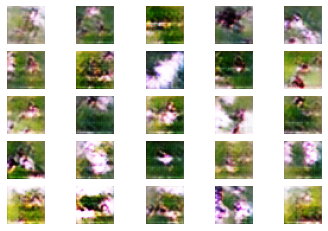

>46, 1/39, d1=0.486, d2=0.778 g=1.838
>46, 2/39, d1=0.666, d2=0.398 g=1.746
>46, 3/39, d1=0.380, d2=0.518 g=1.793
>46, 4/39, d1=0.646, d2=0.391 g=1.664
>46, 5/39, d1=0.462, d2=0.488 g=1.583
>46, 6/39, d1=0.444, d2=0.759 g=1.756
>46, 7/39, d1=0.622, d2=0.465 g=1.540
>46, 8/39, d1=0.654, d2=0.742 g=1.559
>46, 9/39, d1=0.824, d2=0.394 g=1.276
>46, 10/39, d1=0.661, d2=0.698 g=1.192
>46, 11/39, d1=0.683, d2=0.588 g=1.223
>46, 12/39, d1=0.670, d2=0.545 g=1.273
>46, 13/39, d1=0.642, d2=0.458 g=1.302
>46, 14/39, d1=0.694, d2=0.483 g=1.259
>46, 15/39, d1=0.544, d2=0.456 g=1.309
>46, 16/39, d1=0.466, d2=0.446 g=1.475
>46, 17/39, d1=0.559, d2=0.445 g=1.500
>46, 18/39, d1=0.643, d2=0.435 g=1.368
>46, 19/39, d1=0.574, d2=0.654 g=1.386
>46, 20/39, d1=0.650, d2=0.391 g=1.315
>46, 21/39, d1=0.621, d2=0.537 g=1.317
>46, 22/39, d1=0.548, d2=0.576 g=1.449
>46, 23/39, d1=0.622, d2=0.459 g=1.247
>46, 24/39, d1=0.497, d2=0.619 g=1.375
>46, 25/39, d1=0.654, d2=0.502 g=1.444
>46, 26/39, d1=0.726, d2=0.518 g=1

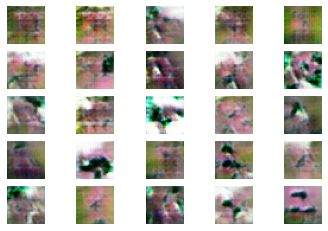

>51, 1/39, d1=0.410, d2=0.423 g=1.557
>51, 2/39, d1=0.528, d2=0.503 g=1.538
>51, 3/39, d1=0.561, d2=0.828 g=1.669
>51, 4/39, d1=0.671, d2=0.387 g=1.628
>51, 5/39, d1=0.772, d2=0.368 g=1.599
>51, 6/39, d1=0.458, d2=0.616 g=1.650
>51, 7/39, d1=0.380, d2=0.406 g=1.707
>51, 8/39, d1=0.363, d2=0.401 g=1.841
>51, 9/39, d1=0.579, d2=0.656 g=2.034
>51, 10/39, d1=0.718, d2=0.361 g=1.736
>51, 11/39, d1=0.407, d2=0.498 g=1.691
>51, 12/39, d1=0.692, d2=0.536 g=1.468
>51, 13/39, d1=0.467, d2=0.984 g=1.628
>51, 14/39, d1=0.646, d2=0.494 g=1.459
>51, 15/39, d1=0.847, d2=0.553 g=1.397
>51, 16/39, d1=0.615, d2=0.669 g=1.400
>51, 17/39, d1=0.676, d2=0.487 g=1.397
>51, 18/39, d1=0.663, d2=0.542 g=1.352
>51, 19/39, d1=0.601, d2=0.409 g=1.352
>51, 20/39, d1=0.493, d2=0.561 g=1.379
>51, 21/39, d1=0.570, d2=0.387 g=1.437
>51, 22/39, d1=0.430, d2=0.451 g=1.393
>51, 23/39, d1=0.344, d2=0.460 g=1.425
>51, 24/39, d1=0.325, d2=0.481 g=1.695
>51, 25/39, d1=0.515, d2=0.532 g=1.496
>51, 26/39, d1=0.514, d2=0.454 g=1

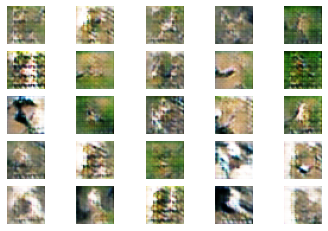

>56, 1/39, d1=0.420, d2=0.464 g=1.984
>56, 2/39, d1=0.656, d2=0.516 g=1.876
>56, 3/39, d1=0.515, d2=0.414 g=1.927
>56, 4/39, d1=0.734, d2=0.467 g=1.961
>56, 5/39, d1=0.725, d2=0.451 g=1.804
>56, 6/39, d1=0.562, d2=0.452 g=1.540
>56, 7/39, d1=0.493, d2=0.533 g=1.596
>56, 8/39, d1=0.528, d2=0.604 g=1.558
>56, 9/39, d1=0.696, d2=0.457 g=1.460
>56, 10/39, d1=0.695, d2=0.494 g=1.345
>56, 11/39, d1=0.668, d2=0.531 g=1.389
>56, 12/39, d1=0.669, d2=0.457 g=1.318
>56, 13/39, d1=0.407, d2=0.429 g=1.558
>56, 14/39, d1=0.426, d2=0.360 g=1.618
>56, 15/39, d1=0.400, d2=0.381 g=1.605
>56, 16/39, d1=0.433, d2=0.389 g=1.675
>56, 17/39, d1=0.410, d2=0.452 g=1.630
>56, 18/39, d1=0.516, d2=0.431 g=1.632
>56, 19/39, d1=0.524, d2=0.333 g=1.550
>56, 20/39, d1=0.555, d2=0.512 g=1.480
>56, 21/39, d1=0.656, d2=0.575 g=1.606
>56, 22/39, d1=0.588, d2=0.331 g=1.647
>56, 23/39, d1=0.567, d2=0.359 g=1.564
>56, 24/39, d1=0.502, d2=0.405 g=1.563
>56, 25/39, d1=0.601, d2=0.385 g=1.465
>56, 26/39, d1=0.523, d2=0.412 g=1

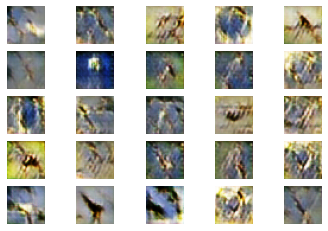

>61, 1/39, d1=0.311, d2=0.458 g=1.656
>61, 2/39, d1=0.325, d2=0.424 g=1.776
>61, 3/39, d1=0.451, d2=0.511 g=1.959
>61, 4/39, d1=0.509, d2=0.601 g=2.038
>61, 5/39, d1=0.737, d2=0.255 g=1.821
>61, 6/39, d1=0.675, d2=0.430 g=1.615
>61, 7/39, d1=0.507, d2=0.358 g=1.495
>61, 8/39, d1=0.531, d2=0.509 g=1.551
>61, 9/39, d1=0.692, d2=0.442 g=1.574
>61, 10/39, d1=0.699, d2=0.379 g=1.626
>61, 11/39, d1=0.568, d2=0.390 g=1.702
>61, 12/39, d1=0.533, d2=0.412 g=1.645
>61, 13/39, d1=0.505, d2=0.354 g=1.545
>61, 14/39, d1=0.479, d2=0.432 g=1.529
>61, 15/39, d1=0.417, d2=0.436 g=1.476
>61, 16/39, d1=0.496, d2=0.547 g=1.428
>61, 17/39, d1=0.445, d2=0.587 g=1.528
>61, 18/39, d1=0.651, d2=1.250 g=1.753
>61, 19/39, d1=0.989, d2=0.281 g=1.582
>61, 20/39, d1=0.805, d2=0.339 g=1.297
>61, 21/39, d1=0.556, d2=0.492 g=1.288
>61, 22/39, d1=0.492, d2=0.589 g=1.305
>61, 23/39, d1=0.489, d2=0.477 g=1.402
>61, 24/39, d1=0.372, d2=0.438 g=1.549
>61, 25/39, d1=0.427, d2=0.410 g=1.526
>61, 26/39, d1=0.424, d2=0.716 g=1

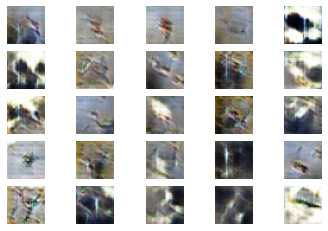

>66, 1/39, d1=0.367, d2=0.432 g=1.538
>66, 2/39, d1=0.696, d2=0.492 g=1.354
>66, 3/39, d1=0.628, d2=0.574 g=1.204
>66, 4/39, d1=0.644, d2=1.701 g=1.309
>66, 5/39, d1=0.626, d2=0.421 g=1.213
>66, 6/39, d1=0.599, d2=0.492 g=1.176
>66, 7/39, d1=0.601, d2=0.543 g=1.232
>66, 8/39, d1=0.660, d2=0.499 g=1.063
>66, 9/39, d1=0.451, d2=0.521 g=1.126
>66, 10/39, d1=0.526, d2=0.595 g=1.100
>66, 11/39, d1=0.493, d2=0.624 g=1.214
>66, 12/39, d1=0.490, d2=0.558 g=1.288
>66, 13/39, d1=0.594, d2=0.738 g=1.273
>66, 14/39, d1=0.711, d2=0.488 g=1.442
>66, 15/39, d1=0.683, d2=0.467 g=1.395
>66, 16/39, d1=0.674, d2=0.469 g=1.390
>66, 17/39, d1=0.595, d2=0.337 g=1.465
>66, 18/39, d1=0.568, d2=0.523 g=1.459
>66, 19/39, d1=0.576, d2=0.538 g=1.426
>66, 20/39, d1=0.505, d2=0.687 g=1.342
>66, 21/39, d1=0.631, d2=0.503 g=1.211
>66, 22/39, d1=0.622, d2=0.590 g=1.102
>66, 23/39, d1=0.509, d2=0.617 g=1.191
>66, 24/39, d1=0.535, d2=0.525 g=1.283
>66, 25/39, d1=0.511, d2=0.554 g=1.281
>66, 26/39, d1=0.520, d2=0.555 g=1

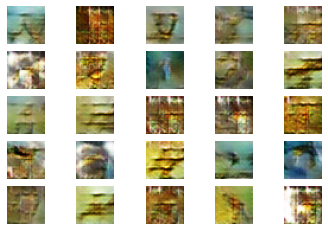

>71, 1/39, d1=0.411, d2=0.356 g=1.492
>71, 2/39, d1=0.488, d2=0.628 g=1.508
>71, 3/39, d1=0.418, d2=0.412 g=1.556
>71, 4/39, d1=0.434, d2=0.411 g=1.531
>71, 5/39, d1=0.509, d2=0.719 g=1.524
>71, 6/39, d1=0.687, d2=0.754 g=1.613
>71, 7/39, d1=0.708, d2=0.439 g=1.535
>71, 8/39, d1=0.579, d2=0.367 g=1.554
>71, 9/39, d1=0.605, d2=0.409 g=1.416
>71, 10/39, d1=0.377, d2=0.567 g=1.506
>71, 11/39, d1=0.358, d2=0.629 g=1.447
>71, 12/39, d1=0.448, d2=0.519 g=1.578
>71, 13/39, d1=0.694, d2=0.472 g=1.527
>71, 14/39, d1=0.447, d2=0.510 g=1.433
>71, 15/39, d1=0.523, d2=0.496 g=1.520
>71, 16/39, d1=0.575, d2=0.605 g=1.575
>71, 17/39, d1=0.519, d2=0.347 g=1.564
>71, 18/39, d1=0.694, d2=0.427 g=1.500
>71, 19/39, d1=0.496, d2=0.380 g=1.392
>71, 20/39, d1=0.433, d2=0.559 g=1.462
>71, 21/39, d1=0.556, d2=0.423 g=1.374
>71, 22/39, d1=0.478, d2=0.535 g=1.406
>71, 23/39, d1=0.384, d2=0.473 g=1.441
>71, 24/39, d1=0.494, d2=0.613 g=1.472
>71, 25/39, d1=0.810, d2=0.950 g=1.666
>71, 26/39, d1=0.959, d2=0.343 g=1

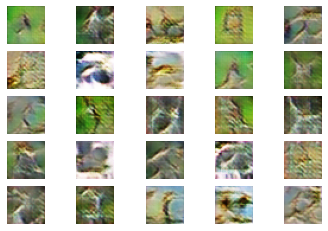

>76, 1/39, d1=0.369, d2=0.405 g=1.504
>76, 2/39, d1=0.376, d2=0.451 g=1.566
>76, 3/39, d1=0.303, d2=0.734 g=1.627
>76, 4/39, d1=0.571, d2=0.424 g=1.601
>76, 5/39, d1=0.589, d2=0.395 g=1.427
>76, 6/39, d1=0.625, d2=0.832 g=1.554
>76, 7/39, d1=0.617, d2=0.338 g=1.488
>76, 8/39, d1=0.529, d2=0.451 g=1.527
>76, 9/39, d1=0.706, d2=0.425 g=1.533
>76, 10/39, d1=0.712, d2=0.461 g=1.413
>76, 11/39, d1=0.570, d2=0.542 g=1.338
>76, 12/39, d1=0.513, d2=0.421 g=1.434
>76, 13/39, d1=0.497, d2=0.406 g=1.343
>76, 14/39, d1=0.369, d2=0.519 g=1.492
>76, 15/39, d1=0.354, d2=0.429 g=1.469
>76, 16/39, d1=0.411, d2=0.490 g=1.538
>76, 17/39, d1=0.579, d2=0.605 g=1.747
>76, 18/39, d1=0.654, d2=0.341 g=1.651
>76, 19/39, d1=0.530, d2=0.389 g=1.509
>76, 20/39, d1=0.595, d2=1.022 g=1.533
>76, 21/39, d1=0.849, d2=0.438 g=1.490
>76, 22/39, d1=0.795, d2=0.348 g=1.402
>76, 23/39, d1=0.634, d2=0.489 g=1.197
>76, 24/39, d1=0.532, d2=0.548 g=1.185
>76, 25/39, d1=0.585, d2=0.611 g=1.196
>76, 26/39, d1=0.591, d2=0.542 g=1

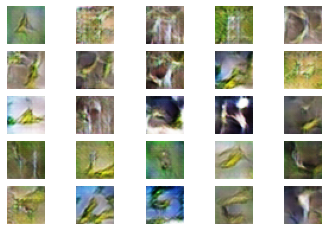

>81, 1/39, d1=0.352, d2=0.634 g=1.402
>81, 2/39, d1=0.522, d2=0.640 g=1.533
>81, 3/39, d1=0.579, d2=0.562 g=1.673
>81, 4/39, d1=0.736, d2=0.356 g=1.524
>81, 5/39, d1=0.786, d2=0.471 g=1.374
>81, 6/39, d1=0.531, d2=0.609 g=1.373
>81, 7/39, d1=0.397, d2=0.451 g=1.345
>81, 8/39, d1=0.480, d2=0.618 g=1.437
>81, 9/39, d1=0.577, d2=0.468 g=1.431
>81, 10/39, d1=0.580, d2=0.396 g=1.442
>81, 11/39, d1=0.505, d2=0.559 g=1.318
>81, 12/39, d1=0.489, d2=0.421 g=1.353
>81, 13/39, d1=0.338, d2=0.444 g=1.423
>81, 14/39, d1=0.551, d2=0.505 g=1.537
>81, 15/39, d1=0.674, d2=0.501 g=1.455
>81, 16/39, d1=0.589, d2=0.393 g=1.296
>81, 17/39, d1=0.577, d2=0.516 g=1.272
>81, 18/39, d1=0.476, d2=0.476 g=1.442
>81, 19/39, d1=0.457, d2=0.558 g=1.489
>81, 20/39, d1=0.382, d2=0.526 g=1.556
>81, 21/39, d1=0.612, d2=0.504 g=1.646
>81, 22/39, d1=0.563, d2=0.389 g=1.614
>81, 23/39, d1=0.651, d2=0.482 g=1.645
>81, 24/39, d1=0.577, d2=0.653 g=1.733
>81, 25/39, d1=0.714, d2=0.308 g=1.657
>81, 26/39, d1=0.585, d2=0.281 g=1

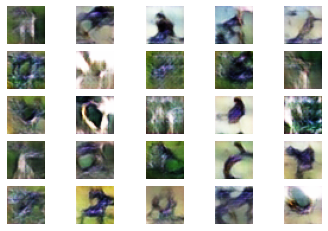

>86, 1/39, d1=0.358, d2=0.373 g=1.561
>86, 2/39, d1=0.519, d2=0.470 g=1.433
>86, 3/39, d1=0.578, d2=0.551 g=1.494
>86, 4/39, d1=0.627, d2=0.514 g=1.514
>86, 5/39, d1=0.569, d2=0.432 g=1.517
>86, 6/39, d1=0.490, d2=0.361 g=1.487
>86, 7/39, d1=0.547, d2=0.442 g=1.393
>86, 8/39, d1=0.617, d2=0.570 g=1.292
>86, 9/39, d1=0.618, d2=0.619 g=1.332
>86, 10/39, d1=0.430, d2=0.415 g=1.441
>86, 11/39, d1=0.564, d2=0.347 g=1.383
>86, 12/39, d1=0.522, d2=0.503 g=1.487
>86, 13/39, d1=0.486, d2=0.467 g=1.558
>86, 14/39, d1=0.539, d2=0.367 g=1.359
>86, 15/39, d1=0.604, d2=1.186 g=1.599
>86, 16/39, d1=0.827, d2=0.426 g=1.424
>86, 17/39, d1=0.795, d2=0.486 g=1.299
>86, 18/39, d1=0.708, d2=0.486 g=1.099
>86, 19/39, d1=0.544, d2=0.721 g=1.103
>86, 20/39, d1=0.417, d2=0.660 g=1.220
>86, 21/39, d1=0.613, d2=0.551 g=1.168
>86, 22/39, d1=0.388, d2=0.517 g=1.168
>86, 23/39, d1=0.478, d2=0.628 g=1.337
>86, 24/39, d1=0.513, d2=0.534 g=1.348
>86, 25/39, d1=0.449, d2=0.485 g=1.423
>86, 26/39, d1=0.654, d2=0.426 g=1

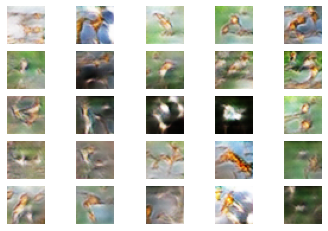

>91, 1/39, d1=0.377, d2=0.390 g=1.511
>91, 2/39, d1=0.548, d2=0.548 g=1.431
>91, 3/39, d1=0.430, d2=0.444 g=1.434
>91, 4/39, d1=0.382, d2=0.547 g=1.488
>91, 5/39, d1=0.510, d2=0.615 g=1.555
>91, 6/39, d1=0.524, d2=0.390 g=1.466
>91, 7/39, d1=0.564, d2=0.523 g=1.366
>91, 8/39, d1=0.638, d2=0.580 g=1.527
>91, 9/39, d1=0.506, d2=0.527 g=1.435
>91, 10/39, d1=0.607, d2=0.392 g=1.358
>91, 11/39, d1=0.601, d2=0.506 g=1.284
>91, 12/39, d1=0.565, d2=0.602 g=1.364
>91, 13/39, d1=0.510, d2=0.466 g=1.375
>91, 14/39, d1=0.557, d2=0.523 g=1.378
>91, 15/39, d1=0.453, d2=0.457 g=1.267
>91, 16/39, d1=0.515, d2=0.583 g=1.350
>91, 17/39, d1=0.560, d2=0.589 g=1.478
>91, 18/39, d1=0.651, d2=0.431 g=1.430
>91, 19/39, d1=0.694, d2=0.445 g=1.196
>91, 20/39, d1=0.665, d2=0.497 g=1.243
>91, 21/39, d1=0.467, d2=0.513 g=1.361
>91, 22/39, d1=0.463, d2=0.457 g=1.441
>91, 23/39, d1=0.592, d2=0.441 g=1.533
>91, 24/39, d1=0.473, d2=0.703 g=1.553
>91, 25/39, d1=0.572, d2=0.429 g=1.424
>91, 26/39, d1=0.705, d2=0.413 g=1

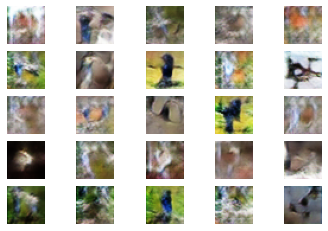

>96, 1/39, d1=0.433, d2=0.605 g=1.352
>96, 2/39, d1=0.570, d2=0.479 g=1.246
>96, 3/39, d1=0.531, d2=0.463 g=1.268
>96, 4/39, d1=0.621, d2=0.490 g=1.360
>96, 5/39, d1=0.557, d2=0.507 g=1.435
>96, 6/39, d1=0.476, d2=0.481 g=1.326
>96, 7/39, d1=0.549, d2=0.795 g=1.339
>96, 8/39, d1=0.487, d2=0.411 g=1.443
>96, 9/39, d1=0.673, d2=0.392 g=1.372
>96, 10/39, d1=0.509, d2=0.585 g=1.307
>96, 11/39, d1=0.495, d2=0.599 g=1.404
>96, 12/39, d1=0.562, d2=0.454 g=1.363
>96, 13/39, d1=0.559, d2=0.439 g=1.247
>96, 14/39, d1=0.403, d2=0.561 g=1.446
>96, 15/39, d1=0.528, d2=0.367 g=1.386
>96, 16/39, d1=0.568, d2=0.534 g=1.313
>96, 17/39, d1=0.599, d2=0.500 g=1.514
>96, 18/39, d1=0.579, d2=0.447 g=1.453
>96, 19/39, d1=0.508, d2=0.410 g=1.349
>96, 20/39, d1=0.509, d2=0.414 g=1.408
>96, 21/39, d1=0.442, d2=0.546 g=1.470
>96, 22/39, d1=0.535, d2=0.451 g=1.484
>96, 23/39, d1=0.595, d2=0.439 g=1.403
>96, 24/39, d1=0.749, d2=0.534 g=1.438
>96, 25/39, d1=0.637, d2=0.377 g=1.356
>96, 26/39, d1=0.634, d2=0.495 g=1

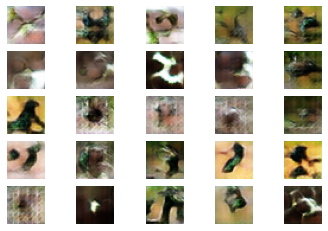

>101, 1/39, d1=0.523, d2=0.734 g=1.545
>101, 2/39, d1=0.647, d2=0.349 g=1.600
>101, 3/39, d1=0.755, d2=0.426 g=1.435
>101, 4/39, d1=0.482, d2=0.420 g=1.442
>101, 5/39, d1=0.484, d2=0.571 g=1.677
>101, 6/39, d1=0.580, d2=0.396 g=1.787
>101, 7/39, d1=0.485, d2=0.668 g=1.946
>101, 8/39, d1=0.689, d2=0.287 g=1.741
>101, 9/39, d1=0.698, d2=0.493 g=1.591
>101, 10/39, d1=0.530, d2=0.363 g=1.571
>101, 11/39, d1=0.540, d2=0.521 g=1.308
>101, 12/39, d1=0.489, d2=0.795 g=1.485
>101, 13/39, d1=0.644, d2=0.373 g=1.499
>101, 14/39, d1=0.691, d2=0.478 g=1.357
>101, 15/39, d1=0.673, d2=0.444 g=1.241
>101, 16/39, d1=0.578, d2=0.495 g=1.229
>101, 17/39, d1=0.540, d2=0.630 g=1.386
>101, 18/39, d1=0.565, d2=0.509 g=1.190
>101, 19/39, d1=0.609, d2=0.495 g=1.259
>101, 20/39, d1=0.567, d2=0.605 g=1.203
>101, 21/39, d1=0.454, d2=0.581 g=1.354
>101, 22/39, d1=0.507, d2=0.408 g=1.445
>101, 23/39, d1=0.530, d2=0.391 g=1.526
>101, 24/39, d1=0.551, d2=0.657 g=1.555
>101, 25/39, d1=0.635, d2=0.596 g=1.460
>101, 26/

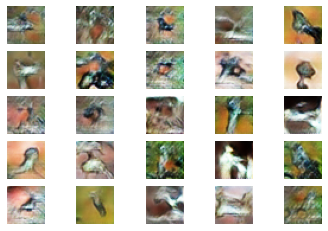

>106, 1/39, d1=0.411, d2=0.488 g=1.221
>106, 2/39, d1=0.608, d2=0.523 g=1.343
>106, 3/39, d1=0.462, d2=0.459 g=1.391
>106, 4/39, d1=0.328, d2=0.514 g=1.419
>106, 5/39, d1=0.638, d2=0.562 g=1.442
>106, 6/39, d1=0.624, d2=0.520 g=1.325
>106, 7/39, d1=0.539, d2=0.524 g=1.345
>106, 8/39, d1=0.546, d2=0.602 g=1.369
>106, 9/39, d1=0.551, d2=0.480 g=1.396
>106, 10/39, d1=0.605, d2=0.510 g=1.237
>106, 11/39, d1=0.513, d2=0.546 g=1.264
>106, 12/39, d1=0.523, d2=0.572 g=1.216
>106, 13/39, d1=0.660, d2=0.542 g=1.277
>106, 14/39, d1=0.515, d2=0.534 g=1.339
>106, 15/39, d1=0.522, d2=0.450 g=1.407
>106, 16/39, d1=0.488, d2=0.517 g=1.391
>106, 17/39, d1=0.473, d2=0.455 g=1.420
>106, 18/39, d1=0.537, d2=0.586 g=1.401
>106, 19/39, d1=0.675, d2=0.473 g=1.371
>106, 20/39, d1=0.527, d2=0.514 g=1.273
>106, 21/39, d1=0.506, d2=0.612 g=1.409
>106, 22/39, d1=0.640, d2=0.461 g=1.357
>106, 23/39, d1=0.586, d2=0.492 g=1.221
>106, 24/39, d1=0.528, d2=0.664 g=1.284
>106, 25/39, d1=0.656, d2=0.472 g=1.316
>106, 26/

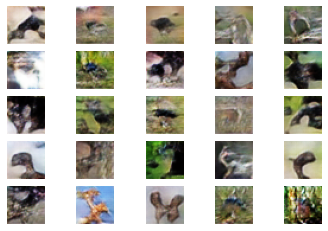

>111, 1/39, d1=0.408, d2=0.602 g=1.350
>111, 2/39, d1=0.472, d2=0.551 g=1.546
>111, 3/39, d1=0.599, d2=0.368 g=1.454
>111, 4/39, d1=0.610, d2=0.434 g=1.368
>111, 5/39, d1=0.395, d2=0.425 g=1.498
>111, 6/39, d1=0.669, d2=0.579 g=1.387
>111, 7/39, d1=0.484, d2=0.529 g=1.455
>111, 8/39, d1=0.474, d2=0.452 g=1.328
>111, 9/39, d1=0.481, d2=0.510 g=1.360
>111, 10/39, d1=0.488, d2=0.490 g=1.303
>111, 11/39, d1=0.593, d2=0.576 g=1.342
>111, 12/39, d1=0.501, d2=0.493 g=1.377
>111, 13/39, d1=0.534, d2=0.640 g=1.369
>111, 14/39, d1=0.641, d2=0.376 g=1.406
>111, 15/39, d1=0.606, d2=0.569 g=1.443
>111, 16/39, d1=0.524, d2=0.480 g=1.439
>111, 17/39, d1=0.471, d2=0.446 g=1.397
>111, 18/39, d1=0.560, d2=0.453 g=1.401
>111, 19/39, d1=0.535, d2=0.697 g=1.323
>111, 20/39, d1=0.623, d2=0.509 g=1.299
>111, 21/39, d1=0.720, d2=0.507 g=1.263
>111, 22/39, d1=0.600, d2=0.518 g=1.392
>111, 23/39, d1=0.586, d2=0.500 g=1.289
>111, 24/39, d1=0.466, d2=0.496 g=1.237
>111, 25/39, d1=0.506, d2=0.696 g=1.269
>111, 26/

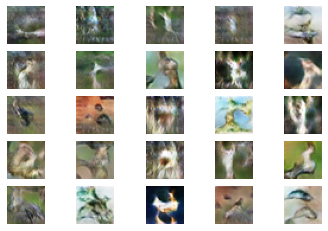

>116, 1/39, d1=0.421, d2=0.441 g=1.444
>116, 2/39, d1=0.655, d2=0.771 g=1.529
>116, 3/39, d1=0.659, d2=0.428 g=1.379
>116, 4/39, d1=0.592, d2=0.491 g=1.332
>116, 5/39, d1=0.583, d2=0.547 g=1.371
>116, 6/39, d1=0.464, d2=0.448 g=1.382
>116, 7/39, d1=0.512, d2=0.641 g=1.433
>116, 8/39, d1=0.508, d2=0.522 g=1.543
>116, 9/39, d1=0.675, d2=0.472 g=1.416
>116, 10/39, d1=0.652, d2=0.563 g=1.342
>116, 11/39, d1=0.599, d2=0.469 g=1.296
>116, 12/39, d1=0.573, d2=0.442 g=1.182
>116, 13/39, d1=0.457, d2=0.499 g=1.255
>116, 14/39, d1=0.463, d2=0.498 g=1.315
>116, 15/39, d1=0.574, d2=0.485 g=1.405
>116, 16/39, d1=0.502, d2=0.376 g=1.423
>116, 17/39, d1=0.553, d2=0.562 g=1.381
>116, 18/39, d1=0.613, d2=0.599 g=1.523
>116, 19/39, d1=0.513, d2=0.339 g=1.484
>116, 20/39, d1=0.577, d2=0.552 g=1.527
>116, 21/39, d1=0.426, d2=0.375 g=1.492
>116, 22/39, d1=0.539, d2=0.520 g=1.391
>116, 23/39, d1=0.524, d2=0.413 g=1.494
>116, 24/39, d1=0.446, d2=0.567 g=1.503
>116, 25/39, d1=0.560, d2=0.445 g=1.317
>116, 26/

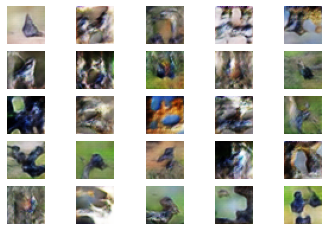

>121, 1/39, d1=0.390, d2=0.376 g=1.299
>121, 2/39, d1=0.530, d2=0.604 g=1.345
>121, 3/39, d1=0.537, d2=0.592 g=1.460
>121, 4/39, d1=0.485, d2=0.435 g=1.583
>121, 5/39, d1=0.622, d2=0.493 g=1.365
>121, 6/39, d1=0.472, d2=0.372 g=1.463
>121, 7/39, d1=0.496, d2=0.607 g=1.480
>121, 8/39, d1=0.466, d2=0.341 g=1.479
>121, 9/39, d1=0.469, d2=0.441 g=1.409
>121, 10/39, d1=0.495, d2=0.493 g=1.571
>121, 11/39, d1=0.587, d2=0.508 g=1.562
>121, 12/39, d1=0.471, d2=0.509 g=1.593
>121, 13/39, d1=0.578, d2=0.435 g=1.449
>121, 14/39, d1=0.551, d2=0.596 g=1.627
>121, 15/39, d1=0.626, d2=0.433 g=1.542
>121, 16/39, d1=0.539, d2=0.426 g=1.545
>121, 17/39, d1=0.534, d2=0.583 g=1.586
>121, 18/39, d1=0.534, d2=0.399 g=1.462
>121, 19/39, d1=0.435, d2=0.607 g=1.527
>121, 20/39, d1=0.724, d2=0.484 g=1.557
>121, 21/39, d1=0.475, d2=0.407 g=1.570
>121, 22/39, d1=0.476, d2=0.425 g=1.391
>121, 23/39, d1=0.354, d2=0.475 g=1.556
>121, 24/39, d1=0.477, d2=0.486 g=1.361
>121, 25/39, d1=0.591, d2=0.551 g=1.460
>121, 26/

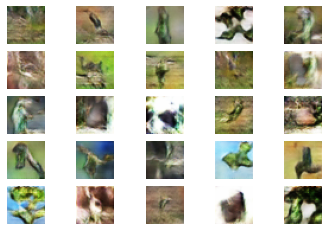

>126, 1/39, d1=0.322, d2=0.458 g=1.749
>126, 2/39, d1=0.586, d2=0.493 g=1.560
>126, 3/39, d1=0.407, d2=0.462 g=1.630
>126, 4/39, d1=0.668, d2=0.407 g=1.551
>126, 5/39, d1=0.442, d2=0.441 g=1.625
>126, 6/39, d1=0.489, d2=0.394 g=1.542
>126, 7/39, d1=0.453, d2=0.489 g=1.566
>126, 8/39, d1=0.518, d2=0.429 g=1.555
>126, 9/39, d1=0.717, d2=0.641 g=1.443
>126, 10/39, d1=0.537, d2=0.472 g=1.510
>126, 11/39, d1=0.659, d2=0.464 g=1.374
>126, 12/39, d1=0.499, d2=0.530 g=1.369
>126, 13/39, d1=0.484, d2=0.555 g=1.388
>126, 14/39, d1=0.683, d2=0.454 g=1.400
>126, 15/39, d1=0.472, d2=0.503 g=1.485
>126, 16/39, d1=0.522, d2=0.584 g=1.646
>126, 17/39, d1=0.487, d2=0.433 g=1.527
>126, 18/39, d1=0.576, d2=0.461 g=1.442
>126, 19/39, d1=0.387, d2=0.541 g=1.637
>126, 20/39, d1=0.515, d2=0.331 g=1.636
>126, 21/39, d1=0.561, d2=0.521 g=1.519
>126, 22/39, d1=0.466, d2=0.511 g=1.624
>126, 23/39, d1=0.604, d2=0.330 g=1.413
>126, 24/39, d1=0.637, d2=0.495 g=1.312
>126, 25/39, d1=0.442, d2=0.508 g=1.352
>126, 26/

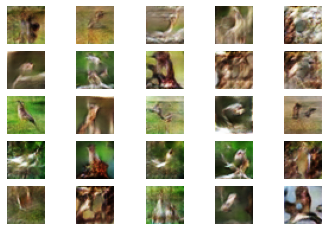

>131, 1/39, d1=0.347, d2=0.516 g=1.689
>131, 2/39, d1=0.523, d2=0.326 g=1.665
>131, 3/39, d1=0.684, d2=0.379 g=1.364
>131, 4/39, d1=0.376, d2=0.795 g=1.557
>131, 5/39, d1=0.536, d2=0.460 g=1.517
>131, 6/39, d1=0.590, d2=0.420 g=1.458
>131, 7/39, d1=0.469, d2=0.415 g=1.427
>131, 8/39, d1=0.431, d2=0.557 g=1.532
>131, 9/39, d1=0.442, d2=0.426 g=1.591
>131, 10/39, d1=0.473, d2=0.488 g=1.600
>131, 11/39, d1=0.502, d2=0.517 g=1.658
>131, 12/39, d1=0.651, d2=0.318 g=1.556
>131, 13/39, d1=0.544, d2=0.525 g=1.490
>131, 14/39, d1=0.535, d2=0.462 g=1.500
>131, 15/39, d1=0.456, d2=0.584 g=1.602
>131, 16/39, d1=0.519, d2=0.400 g=1.549
>131, 17/39, d1=0.538, d2=0.521 g=1.497
>131, 18/39, d1=0.447, d2=0.569 g=1.662
>131, 19/39, d1=0.509, d2=0.404 g=1.631
>131, 20/39, d1=0.505, d2=0.412 g=1.509
>131, 21/39, d1=0.655, d2=0.453 g=1.433
>131, 22/39, d1=0.397, d2=0.571 g=1.627
>131, 23/39, d1=0.538, d2=0.344 g=1.648
>131, 24/39, d1=0.507, d2=0.503 g=1.366
>131, 25/39, d1=0.421, d2=0.550 g=1.437
>131, 26/

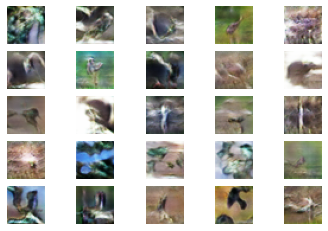

>136, 1/39, d1=0.359, d2=0.529 g=1.682
>136, 2/39, d1=0.495, d2=0.351 g=1.627
>136, 3/39, d1=0.511, d2=0.511 g=1.509
>136, 4/39, d1=0.508, d2=0.560 g=1.671
>136, 5/39, d1=0.531, d2=0.356 g=1.665
>136, 6/39, d1=0.531, d2=0.515 g=1.496
>136, 7/39, d1=0.530, d2=0.630 g=1.556
>136, 8/39, d1=0.503, d2=0.423 g=1.523
>136, 9/39, d1=0.383, d2=0.483 g=1.510
>136, 10/39, d1=0.596, d2=0.439 g=1.605
>136, 11/39, d1=0.492, d2=0.425 g=1.650
>136, 12/39, d1=0.330, d2=0.569 g=1.762
>136, 13/39, d1=0.691, d2=0.598 g=1.698
>136, 14/39, d1=0.567, d2=0.403 g=1.640
>136, 15/39, d1=0.469, d2=0.444 g=1.546
>136, 16/39, d1=0.416, d2=0.480 g=1.575
>136, 17/39, d1=0.624, d2=0.439 g=1.505
>136, 18/39, d1=0.583, d2=0.556 g=1.468
>136, 19/39, d1=0.539, d2=0.458 g=1.421
>136, 20/39, d1=0.492, d2=0.496 g=1.474
>136, 21/39, d1=0.477, d2=0.476 g=1.600
>136, 22/39, d1=0.420, d2=0.393 g=1.549
>136, 23/39, d1=0.306, d2=0.565 g=1.771
>136, 24/39, d1=0.484, d2=0.416 g=1.708
>136, 25/39, d1=0.591, d2=0.629 g=1.564
>136, 26/

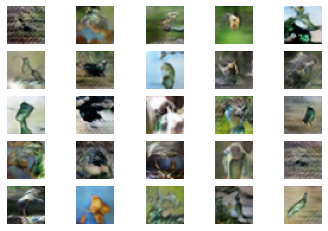

>141, 1/39, d1=0.311, d2=0.471 g=1.600
>141, 2/39, d1=0.530, d2=0.403 g=1.703
>141, 3/39, d1=0.567, d2=0.488 g=1.561
>141, 4/39, d1=0.573, d2=0.460 g=1.615
>141, 5/39, d1=0.570, d2=0.411 g=1.528
>141, 6/39, d1=0.500, d2=0.527 g=1.508
>141, 7/39, d1=0.421, d2=0.432 g=1.572
>141, 8/39, d1=0.643, d2=0.516 g=1.513
>141, 9/39, d1=0.545, d2=0.408 g=1.456
>141, 10/39, d1=0.378, d2=0.645 g=1.609
>141, 11/39, d1=0.390, d2=0.412 g=1.564
>141, 12/39, d1=0.493, d2=0.414 g=1.549
>141, 13/39, d1=0.481, d2=0.442 g=1.451
>141, 14/39, d1=0.458, d2=0.509 g=1.577
>141, 15/39, d1=0.537, d2=0.567 g=1.550
>141, 16/39, d1=0.541, d2=0.485 g=1.508
>141, 17/39, d1=0.396, d2=0.511 g=1.594
>141, 18/39, d1=0.505, d2=0.454 g=1.594
>141, 19/39, d1=0.455, d2=0.569 g=1.571
>141, 20/39, d1=0.603, d2=0.441 g=1.579
>141, 21/39, d1=0.680, d2=0.464 g=1.454
>141, 22/39, d1=0.423, d2=0.464 g=1.487
>141, 23/39, d1=0.421, d2=0.497 g=1.501
>141, 24/39, d1=0.336, d2=0.412 g=1.739
>141, 25/39, d1=0.562, d2=0.398 g=1.668
>141, 26/

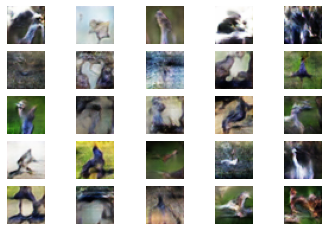

>146, 1/39, d1=0.377, d2=0.502 g=1.762
>146, 2/39, d1=0.558, d2=0.530 g=1.788
>146, 3/39, d1=0.582, d2=0.456 g=1.784
>146, 4/39, d1=0.591, d2=0.485 g=1.614
>146, 5/39, d1=0.516, d2=0.429 g=1.541
>146, 6/39, d1=0.380, d2=0.494 g=1.495
>146, 7/39, d1=0.439, d2=0.367 g=1.696
>146, 8/39, d1=0.567, d2=0.517 g=1.742
>146, 9/39, d1=0.435, d2=0.400 g=1.777
>146, 10/39, d1=0.454, d2=0.434 g=1.770
>146, 11/39, d1=0.567, d2=0.383 g=1.756
>146, 12/39, d1=0.553, d2=0.386 g=1.474
>146, 13/39, d1=0.435, d2=0.645 g=1.691
>146, 14/39, d1=0.454, d2=0.310 g=1.720
>146, 15/39, d1=0.635, d2=0.510 g=1.630
>146, 16/39, d1=0.510, d2=0.447 g=1.577
>146, 17/39, d1=0.451, d2=0.378 g=1.739
>146, 18/39, d1=0.589, d2=0.574 g=1.687
>146, 19/39, d1=0.469, d2=0.423 g=1.605
>146, 20/39, d1=0.359, d2=0.410 g=1.568
>146, 21/39, d1=0.384, d2=0.548 g=1.689
>146, 22/39, d1=0.613, d2=0.361 g=1.657
>146, 23/39, d1=0.506, d2=0.536 g=1.743
>146, 24/39, d1=0.405, d2=0.354 g=1.819
>146, 25/39, d1=0.553, d2=0.545 g=1.643
>146, 26/

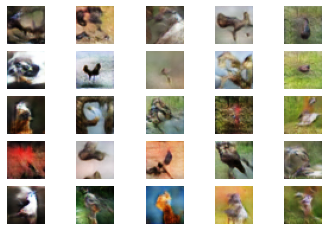

>151, 1/39, d1=0.315, d2=0.361 g=1.678
>151, 2/39, d1=0.469, d2=0.459 g=1.771
>151, 3/39, d1=0.514, d2=0.410 g=1.615
>151, 4/39, d1=0.377, d2=0.347 g=1.692
>151, 5/39, d1=0.331, d2=0.472 g=1.679
>151, 6/39, d1=0.372, d2=0.455 g=1.821
>151, 7/39, d1=0.582, d2=0.437 g=1.913
>151, 8/39, d1=0.483, d2=0.403 g=1.766
>151, 9/39, d1=0.396, d2=0.353 g=1.655
>151, 10/39, d1=0.529, d2=0.592 g=1.658
>151, 11/39, d1=0.383, d2=0.441 g=1.911
>151, 12/39, d1=0.554, d2=0.392 g=1.984
>151, 13/39, d1=0.604, d2=0.410 g=1.811
>151, 14/39, d1=0.495, d2=0.400 g=1.694
>151, 15/39, d1=0.472, d2=0.729 g=1.687
>151, 16/39, d1=0.582, d2=0.348 g=1.643
>151, 17/39, d1=0.580, d2=0.464 g=1.591
>151, 18/39, d1=0.443, d2=0.466 g=1.618
>151, 19/39, d1=0.285, d2=0.352 g=1.788
>151, 20/39, d1=0.509, d2=0.370 g=1.679
>151, 21/39, d1=0.342, d2=0.610 g=1.813
>151, 22/39, d1=0.397, d2=0.323 g=1.868
>151, 23/39, d1=0.610, d2=0.407 g=1.640
>151, 24/39, d1=0.528, d2=0.453 g=1.586
>151, 25/39, d1=0.369, d2=0.523 g=1.831
>151, 26/

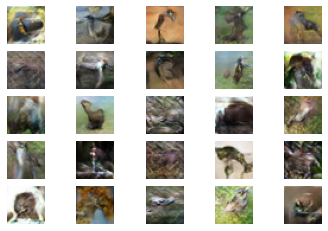

>156, 1/39, d1=0.313, d2=0.470 g=1.694
>156, 2/39, d1=0.458, d2=0.325 g=1.806
>156, 3/39, d1=0.548, d2=0.472 g=1.838
>156, 4/39, d1=0.469, d2=0.478 g=1.728
>156, 5/39, d1=0.654, d2=0.436 g=1.569
>156, 6/39, d1=0.501, d2=0.609 g=1.636
>156, 7/39, d1=0.402, d2=0.456 g=1.922
>156, 8/39, d1=0.482, d2=0.338 g=1.995
>156, 9/39, d1=0.355, d2=0.462 g=1.952
>156, 10/39, d1=0.419, d2=0.353 g=1.909
>156, 11/39, d1=0.477, d2=0.377 g=1.870
>156, 12/39, d1=0.394, d2=0.337 g=1.724
>156, 13/39, d1=0.454, d2=0.396 g=1.673
>156, 14/39, d1=0.388, d2=0.452 g=1.757
>156, 15/39, d1=0.429, d2=0.414 g=1.881
>156, 16/39, d1=0.558, d2=0.291 g=1.685
>156, 17/39, d1=0.521, d2=0.612 g=1.615
>156, 18/39, d1=0.547, d2=0.385 g=1.666
>156, 19/39, d1=0.534, d2=0.528 g=1.654
>156, 20/39, d1=0.514, d2=0.402 g=1.557
>156, 21/39, d1=0.462, d2=0.436 g=1.583
>156, 22/39, d1=0.421, d2=0.522 g=1.637
>156, 23/39, d1=0.439, d2=0.332 g=1.756
>156, 24/39, d1=0.289, d2=0.445 g=1.871
>156, 25/39, d1=0.452, d2=0.461 g=1.983
>156, 26/

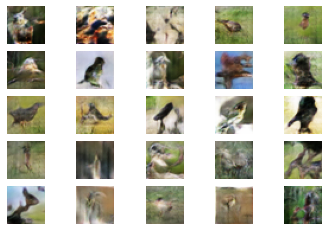

>161, 1/39, d1=0.305, d2=0.432 g=1.694
>161, 2/39, d1=0.522, d2=0.547 g=1.664
>161, 3/39, d1=0.502, d2=0.396 g=1.659
>161, 4/39, d1=0.537, d2=0.492 g=1.636
>161, 5/39, d1=0.441, d2=0.373 g=1.857
>161, 6/39, d1=0.388, d2=0.448 g=1.621
>161, 7/39, d1=0.447, d2=0.583 g=1.769
>161, 8/39, d1=0.523, d2=0.497 g=1.914
>161, 9/39, d1=0.426, d2=0.312 g=1.835
>161, 10/39, d1=0.567, d2=0.401 g=1.712
>161, 11/39, d1=0.383, d2=0.635 g=1.774
>161, 12/39, d1=0.449, d2=0.419 g=1.854
>161, 13/39, d1=0.586, d2=0.421 g=1.818
>161, 14/39, d1=0.574, d2=0.365 g=1.687
>161, 15/39, d1=0.560, d2=0.438 g=1.647
>161, 16/39, d1=0.370, d2=0.611 g=1.672
>161, 17/39, d1=0.289, d2=0.450 g=1.923
>161, 18/39, d1=0.405, d2=0.314 g=1.855
>161, 19/39, d1=0.415, d2=0.513 g=1.777
>161, 20/39, d1=0.410, d2=0.356 g=1.905
>161, 21/39, d1=0.364, d2=0.355 g=2.065
>161, 22/39, d1=0.491, d2=0.400 g=1.856
>161, 23/39, d1=0.398, d2=0.486 g=2.056
>161, 24/39, d1=0.606, d2=0.345 g=1.907
>161, 25/39, d1=0.428, d2=0.334 g=1.716
>161, 26/

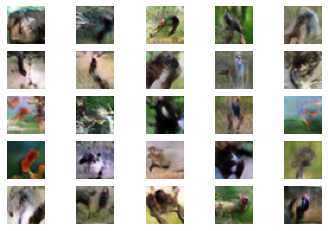

>166, 1/39, d1=0.293, d2=0.633 g=1.832
>166, 2/39, d1=0.506, d2=0.393 g=1.788
>166, 3/39, d1=0.562, d2=0.372 g=1.506
>166, 4/39, d1=0.287, d2=0.539 g=1.819
>166, 5/39, d1=0.490, d2=0.528 g=1.877
>166, 6/39, d1=0.376, d2=0.278 g=1.993
>166, 7/39, d1=0.577, d2=0.416 g=1.944
>166, 8/39, d1=0.413, d2=0.572 g=1.986
>166, 9/39, d1=0.716, d2=0.572 g=1.762
>166, 10/39, d1=0.475, d2=0.393 g=1.720
>166, 11/39, d1=0.363, d2=0.505 g=1.817
>166, 12/39, d1=0.461, d2=0.371 g=1.792
>166, 13/39, d1=0.384, d2=0.414 g=1.804
>166, 14/39, d1=0.473, d2=0.363 g=1.753
>166, 15/39, d1=0.558, d2=0.396 g=1.642
>166, 16/39, d1=0.401, d2=0.342 g=1.749
>166, 17/39, d1=0.492, d2=0.522 g=1.805
>166, 18/39, d1=0.606, d2=0.420 g=1.804
>166, 19/39, d1=0.530, d2=0.491 g=1.863
>166, 20/39, d1=0.308, d2=0.332 g=1.692
>166, 21/39, d1=0.568, d2=0.539 g=1.929
>166, 22/39, d1=0.496, d2=0.390 g=1.763
>166, 23/39, d1=0.361, d2=0.398 g=1.741
>166, 24/39, d1=0.312, d2=0.325 g=1.943
>166, 25/39, d1=0.476, d2=0.411 g=1.723
>166, 26/

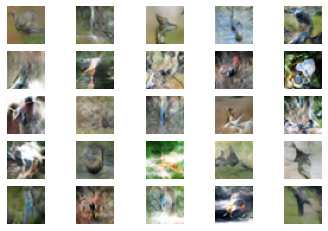

>171, 1/39, d1=0.278, d2=0.364 g=1.769
>171, 2/39, d1=0.628, d2=0.463 g=1.559
>171, 3/39, d1=0.351, d2=0.345 g=1.682
>171, 4/39, d1=0.384, d2=0.440 g=1.772
>171, 5/39, d1=0.451, d2=0.264 g=1.663
>171, 6/39, d1=0.475, d2=0.509 g=1.715
>171, 7/39, d1=0.307, d2=0.574 g=1.919
>171, 8/39, d1=0.512, d2=0.249 g=1.865
>171, 9/39, d1=0.449, d2=0.698 g=1.770
>171, 10/39, d1=0.402, d2=0.324 g=1.837
>171, 11/39, d1=0.491, d2=0.480 g=1.934
>171, 12/39, d1=0.497, d2=0.440 g=1.718
>171, 13/39, d1=0.513, d2=0.443 g=1.681
>171, 14/39, d1=0.459, d2=0.700 g=1.626
>171, 15/39, d1=0.607, d2=0.355 g=1.702
>171, 16/39, d1=0.433, d2=0.442 g=1.710
>171, 17/39, d1=0.529, d2=0.408 g=1.440
>171, 18/39, d1=0.388, d2=0.488 g=1.587
>171, 19/39, d1=0.315, d2=0.520 g=1.873
>171, 20/39, d1=0.396, d2=0.345 g=1.906
>171, 21/39, d1=0.655, d2=0.462 g=1.828
>171, 22/39, d1=0.543, d2=0.495 g=1.737
>171, 23/39, d1=0.488, d2=0.301 g=1.743
>171, 24/39, d1=0.388, d2=0.603 g=1.791
>171, 25/39, d1=0.355, d2=0.343 g=1.843
>171, 26/

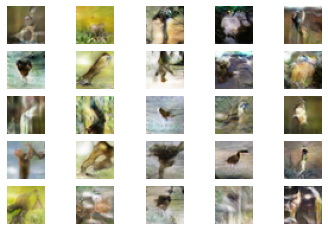

>176, 1/39, d1=0.270, d2=0.350 g=1.963
>176, 2/39, d1=0.379, d2=0.384 g=1.762
>176, 3/39, d1=0.423, d2=0.486 g=2.023
>176, 4/39, d1=0.496, d2=0.315 g=1.943
>176, 5/39, d1=0.458, d2=0.329 g=1.828
>176, 6/39, d1=0.389, d2=0.457 g=1.973
>176, 7/39, d1=0.412, d2=0.339 g=1.979
>176, 8/39, d1=0.484, d2=0.380 g=2.124
>176, 9/39, d1=0.372, d2=0.337 g=1.856
>176, 10/39, d1=0.449, d2=0.603 g=1.961
>176, 11/39, d1=0.545, d2=0.416 g=2.007
>176, 12/39, d1=0.556, d2=0.322 g=1.874
>176, 13/39, d1=0.499, d2=0.561 g=1.753
>176, 14/39, d1=0.449, d2=0.491 g=1.877
>176, 15/39, d1=0.572, d2=0.509 g=1.887
>176, 16/39, d1=0.462, d2=0.443 g=1.852
>176, 17/39, d1=0.386, d2=0.541 g=1.911
>176, 18/39, d1=0.500, d2=0.393 g=1.740
>176, 19/39, d1=0.296, d2=0.449 g=1.918
>176, 20/39, d1=0.558, d2=0.436 g=1.849
>176, 21/39, d1=0.365, d2=0.400 g=1.936
>176, 22/39, d1=0.511, d2=0.435 g=1.855
>176, 23/39, d1=0.514, d2=0.301 g=1.749
>176, 24/39, d1=0.411, d2=0.588 g=1.797
>176, 25/39, d1=0.448, d2=0.292 g=1.947
>176, 26/

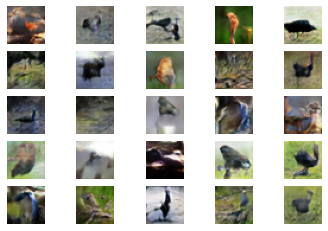

>181, 1/39, d1=0.267, d2=0.610 g=1.974
>181, 2/39, d1=0.524, d2=0.310 g=1.900
>181, 3/39, d1=0.391, d2=0.564 g=1.838
>181, 4/39, d1=0.469, d2=0.289 g=2.024
>181, 5/39, d1=0.419, d2=0.453 g=1.852
>181, 6/39, d1=0.379, d2=0.375 g=1.916
>181, 7/39, d1=0.586, d2=0.393 g=1.776
>181, 8/39, d1=0.358, d2=0.441 g=1.877
>181, 9/39, d1=0.479, d2=0.430 g=1.824
>181, 10/39, d1=0.365, d2=0.404 g=1.836
>181, 11/39, d1=0.440, d2=0.343 g=1.934
>181, 12/39, d1=0.535, d2=0.309 g=1.765
>181, 13/39, d1=0.406, d2=0.549 g=1.951
>181, 14/39, d1=0.523, d2=0.344 g=1.630
>181, 15/39, d1=0.237, d2=0.485 g=1.786
>181, 16/39, d1=0.358, d2=0.443 g=2.058
>181, 17/39, d1=0.521, d2=0.391 g=1.896
>181, 18/39, d1=0.505, d2=0.382 g=1.758
>181, 19/39, d1=0.299, d2=0.530 g=1.830
>181, 20/39, d1=0.460, d2=0.377 g=1.985
>181, 21/39, d1=0.459, d2=0.514 g=1.878
>181, 22/39, d1=0.565, d2=0.509 g=2.009
>181, 23/39, d1=0.520, d2=0.430 g=1.888
>181, 24/39, d1=0.443, d2=0.332 g=1.730
>181, 25/39, d1=0.335, d2=0.484 g=1.840
>181, 26/

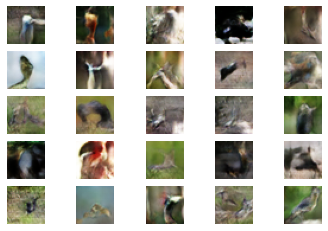

>186, 1/39, d1=0.281, d2=0.367 g=1.780
>186, 2/39, d1=0.490, d2=0.444 g=1.821
>186, 3/39, d1=0.317, d2=0.347 g=1.758
>186, 4/39, d1=0.383, d2=0.434 g=1.999
>186, 5/39, d1=0.566, d2=0.440 g=1.812
>186, 6/39, d1=0.349, d2=0.539 g=2.082
>186, 7/39, d1=0.402, d2=0.235 g=1.862
>186, 8/39, d1=0.520, d2=0.430 g=1.801
>186, 9/39, d1=0.348, d2=0.520 g=1.893
>186, 10/39, d1=0.515, d2=0.290 g=1.850
>186, 11/39, d1=0.372, d2=0.542 g=1.990
>186, 12/39, d1=0.404, d2=0.377 g=2.131
>186, 13/39, d1=0.463, d2=0.347 g=1.793
>186, 14/39, d1=0.300, d2=0.485 g=2.093
>186, 15/39, d1=0.570, d2=0.268 g=1.650
>186, 16/39, d1=0.393, d2=0.463 g=1.771
>186, 17/39, d1=0.346, d2=0.448 g=2.143
>186, 18/39, d1=0.461, d2=0.352 g=2.218
>186, 19/39, d1=0.453, d2=0.346 g=2.129
>186, 20/39, d1=0.491, d2=0.411 g=2.057
>186, 21/39, d1=0.355, d2=0.247 g=1.994
>186, 22/39, d1=0.418, d2=0.534 g=1.857
>186, 23/39, d1=0.399, d2=0.420 g=1.855
>186, 24/39, d1=0.457, d2=0.314 g=1.980
>186, 25/39, d1=0.367, d2=0.479 g=2.038
>186, 26/

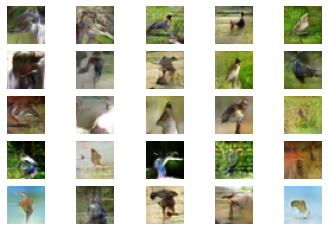

>191, 1/39, d1=0.262, d2=0.507 g=2.076
>191, 2/39, d1=0.449, d2=0.322 g=2.100
>191, 3/39, d1=0.317, d2=0.340 g=2.090
>191, 4/39, d1=0.420, d2=0.458 g=2.037
>191, 5/39, d1=0.407, d2=0.346 g=2.095
>191, 6/39, d1=0.385, d2=0.385 g=2.046
>191, 7/39, d1=0.493, d2=0.440 g=2.018
>191, 8/39, d1=0.420, d2=0.337 g=1.991
>191, 9/39, d1=0.346, d2=0.434 g=1.867
>191, 10/39, d1=0.324, d2=0.458 g=2.454
>191, 11/39, d1=0.585, d2=0.357 g=2.113
>191, 12/39, d1=0.489, d2=0.337 g=1.931
>191, 13/39, d1=0.389, d2=0.535 g=2.072
>191, 14/39, d1=0.429, d2=0.569 g=2.271
>191, 15/39, d1=0.439, d2=0.468 g=2.446
>191, 16/39, d1=0.455, d2=0.318 g=1.989
>191, 17/39, d1=0.457, d2=0.430 g=2.116
>191, 18/39, d1=0.486, d2=0.392 g=1.916
>191, 19/39, d1=0.299, d2=0.336 g=2.047
>191, 20/39, d1=0.507, d2=0.455 g=2.199
>191, 21/39, d1=0.438, d2=0.478 g=2.083
>191, 22/39, d1=0.519, d2=0.435 g=1.915
>191, 23/39, d1=0.616, d2=0.290 g=1.908
>191, 24/39, d1=0.365, d2=0.369 g=1.992
>191, 25/39, d1=0.288, d2=0.285 g=2.090
>191, 26/

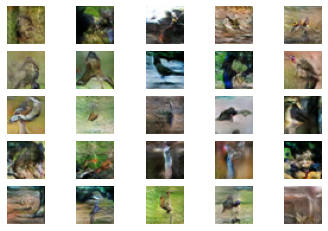

>196, 1/39, d1=0.260, d2=0.270 g=2.021
>196, 2/39, d1=0.569, d2=0.422 g=1.866
>196, 3/39, d1=0.412, d2=0.401 g=1.898
>196, 4/39, d1=0.370, d2=0.557 g=1.878
>196, 5/39, d1=0.404, d2=0.384 g=1.931
>196, 6/39, d1=0.469, d2=0.392 g=1.892
>196, 7/39, d1=0.384, d2=0.435 g=1.930
>196, 8/39, d1=0.370, d2=0.368 g=2.142
>196, 9/39, d1=0.436, d2=0.329 g=1.902
>196, 10/39, d1=0.241, d2=0.354 g=2.052
>196, 11/39, d1=0.561, d2=0.413 g=1.978
>196, 12/39, d1=0.428, d2=0.440 g=2.109
>196, 13/39, d1=0.512, d2=0.406 g=2.050
>196, 14/39, d1=0.385, d2=0.451 g=1.968
>196, 15/39, d1=0.503, d2=0.307 g=1.878
>196, 16/39, d1=0.341, d2=0.512 g=1.898
>196, 17/39, d1=0.359, d2=0.372 g=2.230
>196, 18/39, d1=0.540, d2=0.508 g=2.207
>196, 19/39, d1=0.443, d2=0.345 g=2.033
>196, 20/39, d1=0.313, d2=0.331 g=2.133
>196, 21/39, d1=0.270, d2=0.282 g=2.015
>196, 22/39, d1=0.336, d2=0.426 g=2.140
>196, 23/39, d1=0.546, d2=0.486 g=2.373
>196, 24/39, d1=0.664, d2=0.353 g=1.916
>196, 25/39, d1=0.311, d2=0.427 g=2.271
>196, 26/

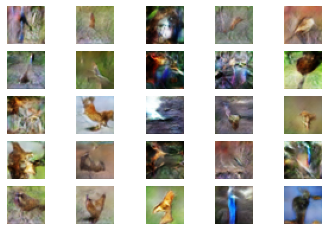

>201, 1/39, d1=0.282, d2=0.327 g=2.315
>201, 2/39, d1=0.236, d2=0.373 g=2.603
>201, 3/39, d1=0.380, d2=0.448 g=2.449
>201, 4/39, d1=0.481, d2=0.392 g=2.245
>201, 5/39, d1=0.463, d2=0.365 g=2.363
>201, 6/39, d1=0.329, d2=0.285 g=2.359
>201, 7/39, d1=0.441, d2=0.487 g=2.226
>201, 8/39, d1=0.282, d2=0.374 g=2.511
>201, 9/39, d1=0.538, d2=0.313 g=2.258
>201, 10/39, d1=0.418, d2=0.303 g=2.264
>201, 11/39, d1=0.456, d2=0.422 g=2.027
>201, 12/39, d1=0.400, d2=0.267 g=2.266
>201, 13/39, d1=0.279, d2=0.319 g=2.347
>201, 14/39, d1=0.298, d2=0.246 g=2.413
>201, 15/39, d1=0.369, d2=0.357 g=2.455
>201, 16/39, d1=0.473, d2=0.324 g=2.189
>201, 17/39, d1=0.245, d2=0.298 g=2.284
>201, 18/39, d1=0.417, d2=0.348 g=2.514
>201, 19/39, d1=0.396, d2=0.450 g=2.217
>201, 20/39, d1=0.591, d2=0.447 g=2.200
>201, 21/39, d1=0.420, d2=0.313 g=2.030
>201, 22/39, d1=0.387, d2=0.384 g=2.179
>201, 23/39, d1=0.539, d2=0.422 g=1.954
>201, 24/39, d1=0.440, d2=0.401 g=2.197
>201, 25/39, d1=0.431, d2=0.221 g=2.116
>201, 26/

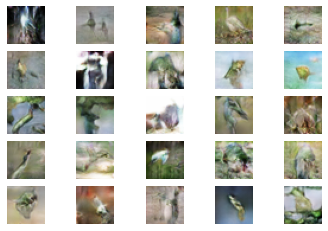

>206, 1/39, d1=0.263, d2=0.338 g=2.095
>206, 2/39, d1=0.352, d2=0.380 g=2.339
>206, 3/39, d1=0.443, d2=0.408 g=2.320
>206, 4/39, d1=0.248, d2=0.349 g=2.339
>206, 5/39, d1=0.306, d2=0.348 g=2.370
>206, 6/39, d1=0.471, d2=0.348 g=2.376
>206, 7/39, d1=0.424, d2=0.292 g=1.908
>206, 8/39, d1=0.314, d2=0.377 g=2.241
>206, 9/39, d1=0.406, d2=0.293 g=2.188
>206, 10/39, d1=0.507, d2=0.418 g=1.891
>206, 11/39, d1=0.246, d2=0.413 g=2.053
>206, 12/39, d1=0.355, d2=0.432 g=2.188
>206, 13/39, d1=0.374, d2=0.333 g=2.179
>206, 14/39, d1=0.421, d2=0.427 g=2.284
>206, 15/39, d1=0.301, d2=0.285 g=2.159
>206, 16/39, d1=0.394, d2=0.381 g=2.149
>206, 17/39, d1=0.375, d2=0.322 g=1.951
>206, 18/39, d1=0.485, d2=0.423 g=2.384
>206, 19/39, d1=0.515, d2=0.302 g=2.047
>206, 20/39, d1=0.231, d2=0.354 g=2.173
>206, 21/39, d1=0.303, d2=0.395 g=2.263
>206, 22/39, d1=0.536, d2=0.427 g=2.207
>206, 23/39, d1=0.338, d2=0.216 g=2.260
>206, 24/39, d1=0.392, d2=0.272 g=1.880
>206, 25/39, d1=0.322, d2=0.516 g=2.297
>206, 26/

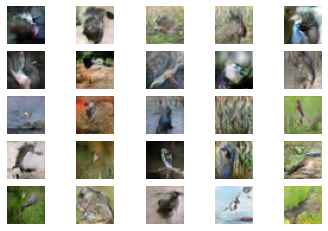

>211, 1/39, d1=0.260, d2=0.300 g=1.948
>211, 2/39, d1=0.324, d2=0.752 g=2.148
>211, 3/39, d1=0.298, d2=0.216 g=2.373
>211, 4/39, d1=0.547, d2=0.462 g=2.077
>211, 5/39, d1=0.326, d2=0.332 g=2.077
>211, 6/39, d1=0.424, d2=0.359 g=2.157
>211, 7/39, d1=0.297, d2=0.363 g=2.311
>211, 8/39, d1=0.314, d2=0.395 g=2.442
>211, 9/39, d1=0.436, d2=0.252 g=2.265
>211, 10/39, d1=0.430, d2=0.460 g=2.099
>211, 11/39, d1=0.433, d2=0.308 g=1.969
>211, 12/39, d1=0.361, d2=0.399 g=2.210
>211, 13/39, d1=0.482, d2=0.355 g=2.153
>211, 14/39, d1=0.364, d2=0.378 g=2.265
>211, 15/39, d1=0.528, d2=0.344 g=1.923
>211, 16/39, d1=0.445, d2=0.399 g=1.905
>211, 17/39, d1=0.267, d2=0.316 g=2.030
>211, 18/39, d1=0.320, d2=0.410 g=2.299
>211, 19/39, d1=0.356, d2=0.333 g=2.070
>211, 20/39, d1=0.344, d2=0.400 g=2.386
>211, 21/39, d1=0.376, d2=0.346 g=2.551
>211, 22/39, d1=0.367, d2=0.272 g=2.440
>211, 23/39, d1=0.317, d2=0.472 g=2.340
>211, 24/39, d1=0.505, d2=0.229 g=2.395
>211, 25/39, d1=0.418, d2=0.459 g=2.108
>211, 26/

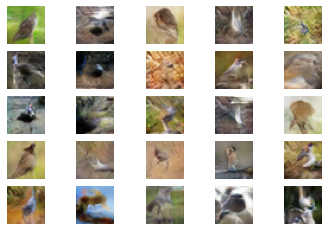

>216, 1/39, d1=0.209, d2=0.328 g=2.186
>216, 2/39, d1=0.351, d2=0.346 g=2.148
>216, 3/39, d1=0.339, d2=0.328 g=2.298
>216, 4/39, d1=0.360, d2=0.357 g=2.235
>216, 5/39, d1=0.493, d2=0.331 g=2.160
>216, 6/39, d1=0.339, d2=0.513 g=2.218
>216, 7/39, d1=0.494, d2=0.403 g=2.076
>216, 8/39, d1=0.380, d2=0.405 g=2.396
>216, 9/39, d1=0.367, d2=0.331 g=2.335
>216, 10/39, d1=0.436, d2=0.399 g=2.022
>216, 11/39, d1=0.373, d2=0.501 g=2.326
>216, 12/39, d1=0.440, d2=0.266 g=2.165
>216, 13/39, d1=0.392, d2=0.334 g=2.104
>216, 14/39, d1=0.389, d2=0.373 g=1.946
>216, 15/39, d1=0.258, d2=0.331 g=2.528
>216, 16/39, d1=0.459, d2=0.395 g=2.431
>216, 17/39, d1=0.469, d2=0.302 g=2.253
>216, 18/39, d1=0.350, d2=0.492 g=2.624
>216, 19/39, d1=0.392, d2=0.280 g=2.390
>216, 20/39, d1=0.262, d2=0.277 g=2.388
>216, 21/39, d1=0.281, d2=0.259 g=2.025
>216, 22/39, d1=0.188, d2=0.540 g=2.407
>216, 23/39, d1=0.353, d2=0.344 g=2.457
>216, 24/39, d1=0.570, d2=0.489 g=2.524
>216, 25/39, d1=0.635, d2=0.275 g=2.118
>216, 26/

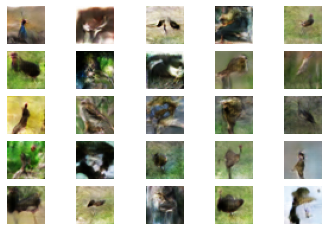

>221, 1/39, d1=0.207, d2=0.257 g=2.451
>221, 2/39, d1=0.370, d2=0.275 g=2.535
>221, 3/39, d1=0.319, d2=0.290 g=2.279
>221, 4/39, d1=0.267, d2=0.319 g=2.458
>221, 5/39, d1=0.383, d2=0.419 g=2.353
>221, 6/39, d1=0.412, d2=0.564 g=2.467
>221, 7/39, d1=0.258, d2=0.313 g=2.277
>221, 8/39, d1=0.470, d2=0.478 g=2.315
>221, 9/39, d1=0.423, d2=0.427 g=2.458
>221, 10/39, d1=0.498, d2=0.286 g=2.327
>221, 11/39, d1=0.414, d2=0.424 g=2.437
>221, 12/39, d1=0.328, d2=0.309 g=2.241
>221, 13/39, d1=0.353, d2=0.438 g=2.313
>221, 14/39, d1=0.472, d2=0.388 g=2.449
>221, 15/39, d1=0.435, d2=0.338 g=2.501
>221, 16/39, d1=0.440, d2=0.412 g=2.458
>221, 17/39, d1=0.414, d2=0.376 g=2.410
>221, 18/39, d1=0.255, d2=0.289 g=2.431
>221, 19/39, d1=0.491, d2=0.432 g=2.123
>221, 20/39, d1=0.351, d2=0.423 g=2.152
>221, 21/39, d1=0.316, d2=0.253 g=2.571
>221, 22/39, d1=0.365, d2=0.204 g=2.655
>221, 23/39, d1=0.201, d2=0.286 g=3.371
>221, 24/39, d1=0.399, d2=0.421 g=2.600
>221, 25/39, d1=0.291, d2=0.367 g=2.342
>221, 26/

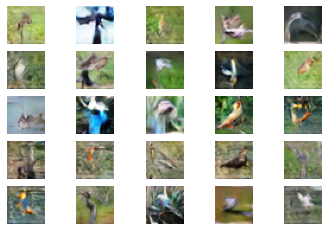

>226, 1/39, d1=0.223, d2=0.323 g=2.215
>226, 2/39, d1=0.303, d2=0.361 g=2.408
>226, 3/39, d1=0.330, d2=0.317 g=2.564
>226, 4/39, d1=0.354, d2=0.363 g=2.620
>226, 5/39, d1=0.262, d2=0.291 g=2.676
>226, 6/39, d1=0.361, d2=0.297 g=2.405
>226, 7/39, d1=0.351, d2=0.278 g=2.269
>226, 8/39, d1=0.375, d2=0.286 g=2.377
>226, 9/39, d1=0.221, d2=0.344 g=2.385
>226, 10/39, d1=0.435, d2=0.328 g=2.303
>226, 11/39, d1=0.289, d2=0.438 g=2.587
>226, 12/39, d1=0.356, d2=0.227 g=2.520
>226, 13/39, d1=0.356, d2=0.357 g=2.270
>226, 14/39, d1=0.480, d2=0.343 g=2.306
>226, 15/39, d1=0.366, d2=0.650 g=2.513
>226, 16/39, d1=0.446, d2=0.329 g=2.321
>226, 17/39, d1=0.381, d2=0.320 g=2.394
>226, 18/39, d1=0.473, d2=0.441 g=2.041
>226, 19/39, d1=0.315, d2=0.326 g=2.145
>226, 20/39, d1=0.309, d2=0.307 g=2.332
>226, 21/39, d1=0.383, d2=0.329 g=2.319
>226, 22/39, d1=0.343, d2=0.369 g=2.297
>226, 23/39, d1=0.422, d2=0.366 g=2.278
>226, 24/39, d1=0.422, d2=0.292 g=2.019
>226, 25/39, d1=0.252, d2=0.354 g=2.289
>226, 26/

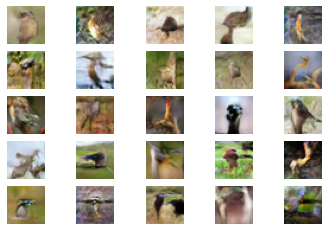

>231, 1/39, d1=0.203, d2=0.347 g=2.734
>231, 2/39, d1=0.520, d2=0.296 g=2.414
>231, 3/39, d1=0.454, d2=0.389 g=2.326
>231, 4/39, d1=0.377, d2=0.328 g=2.527
>231, 5/39, d1=0.415, d2=0.346 g=2.339
>231, 6/39, d1=0.281, d2=0.305 g=2.429
>231, 7/39, d1=0.393, d2=0.335 g=2.369
>231, 8/39, d1=0.323, d2=0.399 g=2.491
>231, 9/39, d1=0.314, d2=0.337 g=2.576
>231, 10/39, d1=0.309, d2=0.332 g=2.528
>231, 11/39, d1=0.340, d2=0.307 g=2.597
>231, 12/39, d1=0.456, d2=0.330 g=2.443
>231, 13/39, d1=0.300, d2=0.362 g=2.603
>231, 14/39, d1=0.336, d2=0.330 g=2.665
>231, 15/39, d1=0.236, d2=0.332 g=2.701
>231, 16/39, d1=0.349, d2=0.620 g=2.934
>231, 17/39, d1=0.552, d2=0.203 g=2.540
>231, 18/39, d1=0.431, d2=0.456 g=2.398
>231, 19/39, d1=0.370, d2=0.302 g=2.370
>231, 20/39, d1=0.388, d2=0.456 g=2.693
>231, 21/39, d1=0.364, d2=0.269 g=2.185
>231, 22/39, d1=0.401, d2=0.404 g=2.383
>231, 23/39, d1=0.389, d2=0.368 g=2.372
>231, 24/39, d1=0.288, d2=0.248 g=2.229
>231, 25/39, d1=0.262, d2=0.388 g=2.658
>231, 26/

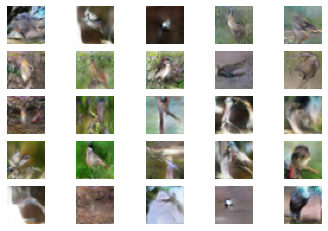

>236, 1/39, d1=0.173, d2=0.324 g=2.274
>236, 2/39, d1=0.326, d2=0.339 g=2.478
>236, 3/39, d1=0.317, d2=0.313 g=2.989
>236, 4/39, d1=0.476, d2=0.323 g=2.375
>236, 5/39, d1=0.217, d2=0.342 g=2.519
>236, 6/39, d1=0.278, d2=0.360 g=2.655
>236, 7/39, d1=0.564, d2=0.286 g=2.519
>236, 8/39, d1=0.288, d2=0.324 g=2.472
>236, 9/39, d1=0.356, d2=0.479 g=2.300
>236, 10/39, d1=0.344, d2=0.323 g=2.392
>236, 11/39, d1=0.362, d2=0.343 g=2.705
>236, 12/39, d1=0.430, d2=0.383 g=2.155
>236, 13/39, d1=0.333, d2=0.441 g=2.463
>236, 14/39, d1=0.272, d2=0.330 g=2.943
>236, 15/39, d1=0.493, d2=0.228 g=2.742
>236, 16/39, d1=0.404, d2=0.440 g=2.420
>236, 17/39, d1=0.348, d2=0.350 g=2.517
>236, 18/39, d1=0.342, d2=0.371 g=2.352
>236, 19/39, d1=0.253, d2=0.302 g=2.529
>236, 20/39, d1=0.363, d2=0.431 g=2.645
>236, 21/39, d1=0.458, d2=0.304 g=2.230
>236, 22/39, d1=0.386, d2=0.376 g=2.208
>236, 23/39, d1=0.202, d2=0.473 g=2.623
>236, 24/39, d1=0.404, d2=0.308 g=2.817
>236, 25/39, d1=0.337, d2=0.207 g=2.465
>236, 26/

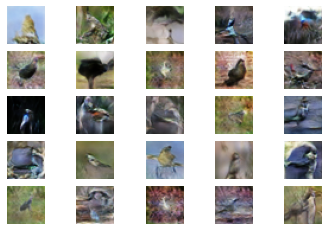

>241, 1/39, d1=0.208, d2=0.233 g=2.737
>241, 2/39, d1=0.413, d2=0.535 g=2.822
>241, 3/39, d1=0.499, d2=0.367 g=2.743
>241, 4/39, d1=0.314, d2=0.344 g=2.357
>241, 5/39, d1=0.490, d2=0.283 g=2.460
>241, 6/39, d1=0.417, d2=0.329 g=2.305
>241, 7/39, d1=0.213, d2=0.572 g=2.856
>241, 8/39, d1=0.339, d2=0.276 g=2.715
>241, 9/39, d1=0.381, d2=0.320 g=2.652
>241, 10/39, d1=0.400, d2=0.424 g=2.740
>241, 11/39, d1=0.325, d2=0.381 g=2.753
>241, 12/39, d1=0.318, d2=0.282 g=2.707
>241, 13/39, d1=0.336, d2=0.263 g=2.485
>241, 14/39, d1=0.490, d2=0.433 g=2.508
>241, 15/39, d1=0.428, d2=0.328 g=2.662
>241, 16/39, d1=0.204, d2=0.230 g=2.849
>241, 17/39, d1=0.368, d2=0.359 g=2.821
>241, 18/39, d1=0.392, d2=0.411 g=2.792
>241, 19/39, d1=0.415, d2=0.288 g=2.583
>241, 20/39, d1=0.377, d2=0.299 g=2.273
>241, 21/39, d1=0.269, d2=0.325 g=2.623
>241, 22/39, d1=0.503, d2=0.316 g=2.540
>241, 23/39, d1=0.267, d2=0.440 g=2.698
>241, 24/39, d1=0.324, d2=0.214 g=2.128
>241, 25/39, d1=0.388, d2=0.382 g=2.303
>241, 26/

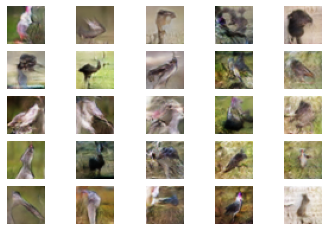

>246, 1/39, d1=0.187, d2=0.482 g=2.518
>246, 2/39, d1=0.587, d2=0.281 g=2.594
>246, 3/39, d1=0.441, d2=0.217 g=2.265
>246, 4/39, d1=0.376, d2=0.370 g=2.373
>246, 5/39, d1=0.296, d2=0.387 g=2.644
>246, 6/39, d1=0.331, d2=0.274 g=2.635
>246, 7/39, d1=0.271, d2=0.376 g=2.690
>246, 8/39, d1=0.286, d2=0.414 g=2.683
>246, 9/39, d1=0.441, d2=0.249 g=2.369
>246, 10/39, d1=0.368, d2=0.274 g=2.220
>246, 11/39, d1=0.222, d2=0.360 g=2.330
>246, 12/39, d1=0.223, d2=0.304 g=2.543
>246, 13/39, d1=0.388, d2=0.282 g=2.392
>246, 14/39, d1=0.365, d2=0.407 g=2.216
>246, 15/39, d1=0.183, d2=0.315 g=2.783
>246, 16/39, d1=0.411, d2=0.502 g=2.673
>246, 17/39, d1=0.430, d2=0.403 g=2.678
>246, 18/39, d1=0.358, d2=0.289 g=2.358
>246, 19/39, d1=0.307, d2=0.279 g=2.271
>246, 20/39, d1=0.348, d2=0.314 g=2.521
>246, 21/39, d1=0.275, d2=0.265 g=2.487
>246, 22/39, d1=0.420, d2=0.280 g=2.453
>246, 23/39, d1=0.215, d2=0.281 g=2.641
>246, 24/39, d1=0.255, d2=0.403 g=2.661
>246, 25/39, d1=0.376, d2=0.225 g=2.576
>246, 26/

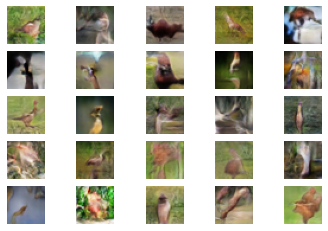

>251, 1/39, d1=0.205, d2=0.300 g=2.578
>251, 2/39, d1=0.321, d2=0.386 g=2.804
>251, 3/39, d1=0.328, d2=0.246 g=2.824
>251, 4/39, d1=0.324, d2=0.233 g=2.791
>251, 5/39, d1=0.397, d2=0.440 g=2.242
>251, 6/39, d1=0.198, d2=0.603 g=2.982
>251, 7/39, d1=0.384, d2=0.280 g=2.689
>251, 8/39, d1=0.338, d2=0.461 g=2.829
>251, 9/39, d1=0.540, d2=0.229 g=2.369
>251, 10/39, d1=0.276, d2=0.321 g=2.288
>251, 11/39, d1=0.263, d2=0.377 g=2.647
>251, 12/39, d1=0.410, d2=0.578 g=2.788
>251, 13/39, d1=0.318, d2=0.337 g=2.493
>251, 14/39, d1=0.253, d2=0.308 g=2.944
>251, 15/39, d1=0.499, d2=0.368 g=2.612
>251, 16/39, d1=0.309, d2=0.472 g=2.529
>251, 17/39, d1=0.453, d2=0.369 g=2.468
>251, 18/39, d1=0.269, d2=0.251 g=2.667
>251, 19/39, d1=0.320, d2=0.391 g=2.765
>251, 20/39, d1=0.327, d2=0.204 g=2.469
>251, 21/39, d1=0.236, d2=0.360 g=2.551
>251, 22/39, d1=0.352, d2=0.189 g=2.475
>251, 23/39, d1=0.267, d2=0.338 g=2.447
>251, 24/39, d1=0.333, d2=0.441 g=2.538
>251, 25/39, d1=0.352, d2=0.382 g=2.940
>251, 26/

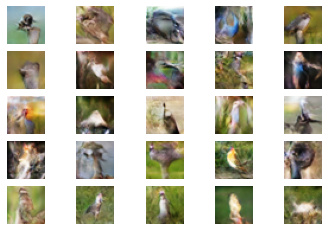

>256, 1/39, d1=0.174, d2=0.323 g=2.617
>256, 2/39, d1=0.201, d2=0.267 g=2.913
>256, 3/39, d1=0.300, d2=0.309 g=2.965
>256, 4/39, d1=0.199, d2=0.214 g=2.777
>256, 5/39, d1=0.372, d2=0.415 g=3.184
>256, 6/39, d1=0.392, d2=0.210 g=2.526
>256, 7/39, d1=0.274, d2=0.417 g=2.789
>256, 8/39, d1=0.220, d2=0.200 g=3.033
>256, 9/39, d1=0.404, d2=0.339 g=2.798
>256, 10/39, d1=0.321, d2=0.214 g=2.821
>256, 11/39, d1=0.285, d2=0.417 g=2.521
>256, 12/39, d1=0.224, d2=0.363 g=3.295
>256, 13/39, d1=0.217, d2=0.233 g=3.181
>256, 14/39, d1=0.491, d2=0.202 g=2.750
>256, 15/39, d1=0.209, d2=0.466 g=3.282
>256, 16/39, d1=0.438, d2=0.274 g=2.712
>256, 17/39, d1=0.416, d2=0.203 g=2.680
>256, 18/39, d1=0.317, d2=0.515 g=2.794
>256, 19/39, d1=0.480, d2=0.205 g=2.728
>256, 20/39, d1=0.196, d2=0.283 g=2.783
>256, 21/39, d1=0.313, d2=0.453 g=2.648
>256, 22/39, d1=0.349, d2=0.435 g=2.798
>256, 23/39, d1=0.625, d2=0.324 g=2.253
>256, 24/39, d1=0.358, d2=0.477 g=2.386
>256, 25/39, d1=0.360, d2=0.366 g=2.525
>256, 26/

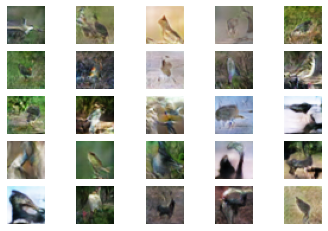

>261, 1/39, d1=0.219, d2=0.156 g=3.003
>261, 2/39, d1=0.358, d2=0.374 g=2.953
>261, 3/39, d1=0.307, d2=0.506 g=2.893
>261, 4/39, d1=0.312, d2=0.320 g=2.782
>261, 5/39, d1=0.304, d2=0.253 g=2.808
>261, 6/39, d1=0.310, d2=0.294 g=2.863
>261, 7/39, d1=0.360, d2=0.237 g=2.595
>261, 8/39, d1=0.162, d2=0.245 g=2.770
>261, 9/39, d1=0.166, d2=0.198 g=3.149
>261, 10/39, d1=0.315, d2=0.161 g=2.736
>261, 11/39, d1=0.454, d2=0.389 g=2.827
>261, 12/39, d1=0.339, d2=0.323 g=2.269
>261, 13/39, d1=0.279, d2=0.320 g=2.725
>261, 14/39, d1=0.242, d2=0.456 g=3.197
>261, 15/39, d1=0.339, d2=0.172 g=3.056
>261, 16/39, d1=0.310, d2=0.186 g=2.773
>261, 17/39, d1=0.436, d2=0.290 g=2.365
>261, 18/39, d1=0.180, d2=0.415 g=2.892
>261, 19/39, d1=0.580, d2=0.523 g=2.869
>261, 20/39, d1=0.349, d2=0.241 g=2.432
>261, 21/39, d1=0.375, d2=0.386 g=2.676
>261, 22/39, d1=0.185, d2=0.273 g=2.880
>261, 23/39, d1=0.360, d2=0.212 g=2.897
>261, 24/39, d1=0.247, d2=0.222 g=2.618
>261, 25/39, d1=0.171, d2=0.210 g=2.599
>261, 26/

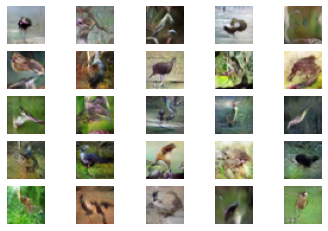

>266, 1/39, d1=0.179, d2=0.153 g=3.175
>266, 2/39, d1=0.258, d2=0.372 g=3.008
>266, 3/39, d1=0.334, d2=0.192 g=2.705
>266, 4/39, d1=0.311, d2=0.397 g=2.624
>266, 5/39, d1=0.298, d2=0.189 g=2.572
>266, 6/39, d1=0.162, d2=0.328 g=3.198
>266, 7/39, d1=0.290, d2=0.218 g=2.950
>266, 8/39, d1=0.198, d2=0.398 g=3.159
>266, 9/39, d1=0.333, d2=0.205 g=2.998
>266, 10/39, d1=0.255, d2=0.336 g=2.649
>266, 11/39, d1=0.425, d2=0.337 g=2.533
>266, 12/39, d1=0.300, d2=0.385 g=2.829
>266, 13/39, d1=0.265, d2=0.194 g=2.807
>266, 14/39, d1=0.318, d2=0.312 g=2.533
>266, 15/39, d1=0.342, d2=0.469 g=2.966
>266, 16/39, d1=0.359, d2=0.392 g=2.929
>266, 17/39, d1=0.382, d2=0.184 g=2.673
>266, 18/39, d1=0.229, d2=0.368 g=2.721
>266, 19/39, d1=0.303, d2=0.315 g=3.046
>266, 20/39, d1=0.277, d2=0.483 g=2.990
>266, 21/39, d1=0.312, d2=0.193 g=2.446
>266, 22/39, d1=0.204, d2=0.282 g=2.471
>266, 23/39, d1=0.328, d2=0.597 g=2.992
>266, 24/39, d1=0.283, d2=0.200 g=3.547
>266, 25/39, d1=0.365, d2=0.301 g=2.979
>266, 26/

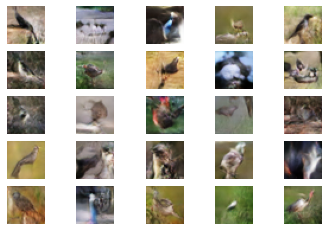

>271, 1/39, d1=0.191, d2=0.208 g=2.941
>271, 2/39, d1=0.376, d2=0.312 g=2.679
>271, 3/39, d1=0.282, d2=0.432 g=2.820
>271, 4/39, d1=0.334, d2=0.203 g=2.707
>271, 5/39, d1=0.235, d2=0.417 g=3.017
>271, 6/39, d1=0.369, d2=0.270 g=3.158
>271, 7/39, d1=0.328, d2=0.248 g=3.082
>271, 8/39, d1=0.297, d2=0.285 g=2.566
>271, 9/39, d1=0.221, d2=0.286 g=2.684
>271, 10/39, d1=0.237, d2=0.305 g=3.103
>271, 11/39, d1=0.282, d2=0.381 g=3.075
>271, 12/39, d1=0.390, d2=0.160 g=2.727
>271, 13/39, d1=0.238, d2=0.260 g=2.931
>271, 14/39, d1=0.209, d2=0.595 g=3.437
>271, 15/39, d1=0.262, d2=0.209 g=3.136
>271, 16/39, d1=0.339, d2=0.381 g=3.157
>271, 17/39, d1=0.337, d2=0.234 g=3.112
>271, 18/39, d1=0.518, d2=0.222 g=2.692
>271, 19/39, d1=0.173, d2=0.458 g=3.035
>271, 20/39, d1=0.285, d2=0.239 g=3.080
>271, 21/39, d1=0.348, d2=0.444 g=3.254
>271, 22/39, d1=0.485, d2=0.312 g=2.987
>271, 23/39, d1=0.336, d2=0.434 g=3.202
>271, 24/39, d1=0.379, d2=0.250 g=2.814
>271, 25/39, d1=0.388, d2=0.303 g=2.735
>271, 26/

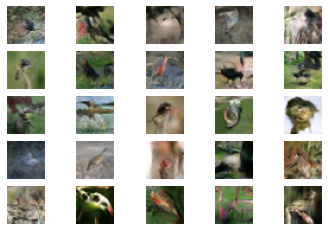

>276, 1/39, d1=0.190, d2=0.321 g=3.277
>276, 2/39, d1=0.478, d2=0.273 g=3.182
>276, 3/39, d1=0.351, d2=0.319 g=2.823
>276, 4/39, d1=0.361, d2=0.354 g=2.677
>276, 5/39, d1=0.312, d2=0.445 g=2.655
>276, 6/39, d1=0.297, d2=0.325 g=3.024
>276, 7/39, d1=0.343, d2=0.358 g=3.036
>276, 8/39, d1=0.276, d2=0.199 g=3.045
>276, 9/39, d1=0.183, d2=0.164 g=2.874
>276, 10/39, d1=0.136, d2=0.317 g=3.515
>276, 11/39, d1=0.374, d2=0.280 g=2.984
>276, 12/39, d1=0.236, d2=0.191 g=3.254
>276, 13/39, d1=0.199, d2=0.374 g=2.838
>276, 14/39, d1=0.211, d2=0.234 g=3.265
>276, 15/39, d1=0.294, d2=0.297 g=3.428
>276, 16/39, d1=0.605, d2=0.217 g=2.620
>276, 17/39, d1=0.232, d2=0.545 g=2.602
>276, 18/39, d1=0.354, d2=0.382 g=3.016
>276, 19/39, d1=0.293, d2=0.184 g=3.009
>276, 20/39, d1=0.303, d2=0.396 g=2.895
>276, 21/39, d1=0.252, d2=0.344 g=2.907
>276, 22/39, d1=0.386, d2=0.342 g=3.026
>276, 23/39, d1=0.290, d2=0.192 g=3.107
>276, 24/39, d1=0.343, d2=0.306 g=2.890
>276, 25/39, d1=0.148, d2=0.266 g=3.265
>276, 26/

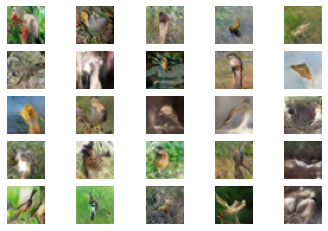

>281, 1/39, d1=0.154, d2=0.384 g=3.640
>281, 2/39, d1=0.470, d2=0.290 g=3.391
>281, 3/39, d1=0.334, d2=0.228 g=3.153
>281, 4/39, d1=0.227, d2=0.246 g=3.180
>281, 5/39, d1=0.360, d2=0.317 g=3.214
>281, 6/39, d1=0.416, d2=0.191 g=2.837
>281, 7/39, d1=0.211, d2=0.366 g=2.978
>281, 8/39, d1=0.279, d2=0.194 g=2.907
>281, 9/39, d1=0.239, d2=0.420 g=3.335
>281, 10/39, d1=0.197, d2=0.122 g=3.199
>281, 11/39, d1=0.215, d2=0.215 g=3.168
>281, 12/39, d1=0.430, d2=0.429 g=2.674
>281, 13/39, d1=0.165, d2=0.280 g=3.184
>281, 14/39, d1=0.400, d2=0.253 g=3.280
>281, 15/39, d1=0.268, d2=0.331 g=3.644
>281, 16/39, d1=0.456, d2=0.181 g=3.225
>281, 17/39, d1=0.244, d2=0.253 g=3.151
>281, 18/39, d1=0.299, d2=0.324 g=2.755
>281, 19/39, d1=0.344, d2=0.278 g=2.837
>281, 20/39, d1=0.154, d2=0.380 g=3.237
>281, 21/39, d1=0.312, d2=0.205 g=3.272
>281, 22/39, d1=0.372, d2=0.246 g=3.165
>281, 23/39, d1=0.136, d2=0.321 g=3.473
>281, 24/39, d1=0.283, d2=0.271 g=3.472
>281, 25/39, d1=0.332, d2=0.273 g=2.927
>281, 26/

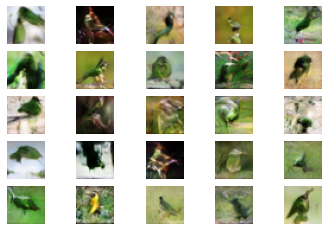

>286, 1/39, d1=0.194, d2=0.303 g=3.117
>286, 2/39, d1=0.229, d2=0.324 g=2.842
>286, 3/39, d1=0.303, d2=0.306 g=2.903
>286, 4/39, d1=0.198, d2=0.297 g=2.943
>286, 5/39, d1=0.221, d2=0.352 g=3.220
>286, 6/39, d1=0.244, d2=0.302 g=3.089
>286, 7/39, d1=0.365, d2=0.245 g=3.247
>286, 8/39, d1=0.264, d2=0.228 g=3.132
>286, 9/39, d1=0.223, d2=0.236 g=3.283
>286, 10/39, d1=0.261, d2=0.274 g=3.106
>286, 11/39, d1=0.292, d2=0.239 g=2.907
>286, 12/39, d1=0.173, d2=0.334 g=2.913
>286, 13/39, d1=0.362, d2=0.201 g=3.116
>286, 14/39, d1=0.300, d2=0.523 g=2.706
>286, 15/39, d1=0.362, d2=0.166 g=2.952
>286, 16/39, d1=0.225, d2=0.583 g=3.231
>286, 17/39, d1=0.495, d2=0.257 g=2.865
>286, 18/39, d1=0.236, d2=0.340 g=2.992
>286, 19/39, d1=0.245, d2=0.277 g=3.573
>286, 20/39, d1=0.373, d2=0.243 g=2.780
>286, 21/39, d1=0.282, d2=0.330 g=3.085
>286, 22/39, d1=0.377, d2=0.241 g=2.536
>286, 23/39, d1=0.328, d2=0.321 g=2.709
>286, 24/39, d1=0.273, d2=0.260 g=2.797
>286, 25/39, d1=0.245, d2=0.268 g=2.971
>286, 26/

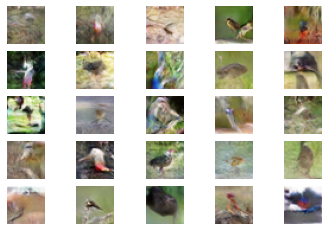

>291, 1/39, d1=0.211, d2=0.379 g=3.097
>291, 2/39, d1=0.305, d2=0.292 g=3.358
>291, 3/39, d1=0.212, d2=0.185 g=3.062
>291, 4/39, d1=0.278, d2=0.222 g=3.247
>291, 5/39, d1=0.416, d2=0.428 g=3.004
>291, 6/39, d1=0.181, d2=0.239 g=3.462
>291, 7/39, d1=0.448, d2=0.260 g=3.229
>291, 8/39, d1=0.342, d2=0.393 g=2.856
>291, 9/39, d1=0.255, d2=0.550 g=3.170
>291, 10/39, d1=0.401, d2=0.280 g=2.919
>291, 11/39, d1=0.301, d2=0.177 g=3.103
>291, 12/39, d1=0.258, d2=0.336 g=3.257
>291, 13/39, d1=0.162, d2=0.202 g=3.042
>291, 14/39, d1=0.283, d2=0.182 g=2.879
>291, 15/39, d1=0.275, d2=0.210 g=2.605
>291, 16/39, d1=0.226, d2=0.416 g=3.081
>291, 17/39, d1=0.202, d2=0.177 g=3.187
>291, 18/39, d1=0.523, d2=0.344 g=2.754
>291, 19/39, d1=0.224, d2=0.406 g=3.104
>291, 20/39, d1=0.252, d2=0.238 g=3.372
>291, 21/39, d1=0.247, d2=0.159 g=2.860
>291, 22/39, d1=0.323, d2=0.217 g=2.690
>291, 23/39, d1=0.191, d2=0.396 g=2.937
>291, 24/39, d1=0.391, d2=0.325 g=3.073
>291, 25/39, d1=0.212, d2=0.294 g=3.179
>291, 26/

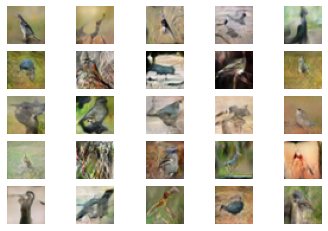

>296, 1/39, d1=0.181, d2=0.259 g=2.954
>296, 2/39, d1=0.286, d2=0.222 g=2.968
>296, 3/39, d1=0.141, d2=0.418 g=3.309
>296, 4/39, d1=0.414, d2=0.193 g=2.965
>296, 5/39, d1=0.406, d2=0.290 g=2.894
>296, 6/39, d1=0.189, d2=0.340 g=3.788
>296, 7/39, d1=0.242, d2=0.089 g=3.065
>296, 8/39, d1=0.166, d2=0.320 g=3.835
>296, 9/39, d1=0.291, d2=0.131 g=3.032
>296, 10/39, d1=0.373, d2=0.537 g=2.726
>296, 11/39, d1=0.195, d2=0.289 g=3.738
>296, 12/39, d1=0.329, d2=0.257 g=3.480
>296, 13/39, d1=0.330, d2=0.238 g=3.483
>296, 14/39, d1=0.247, d2=0.464 g=3.562
>296, 15/39, d1=0.224, d2=0.225 g=3.565
>296, 16/39, d1=0.232, d2=0.117 g=3.406
>296, 17/39, d1=0.376, d2=0.321 g=3.030
>296, 18/39, d1=0.234, d2=0.380 g=2.979
>296, 19/39, d1=0.168, d2=0.235 g=3.491
>296, 20/39, d1=0.444, d2=0.285 g=3.107
>296, 21/39, d1=0.270, d2=0.474 g=3.228
>296, 22/39, d1=0.313, d2=0.287 g=3.323
>296, 23/39, d1=0.358, d2=0.205 g=3.028
>296, 24/39, d1=0.122, d2=0.431 g=3.607
>296, 25/39, d1=0.365, d2=0.250 g=3.627
>296, 26/

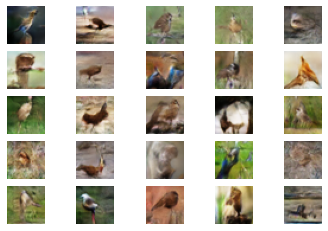

In [ ]:
# size of latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)